# Library Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline

import math
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

import random
import re
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

# Data Import

In [2]:
df_cal = pd.read_csv('calendar.csv')
df = pd.read_csv('sales_train_validation.csv')
df_prices = pd.read_csv('sell_prices.csv')
df_submit = pd.read_csv('sample_submission.csv')

In [3]:
df_cal.fillna('None', inplace = True)

In [4]:
df_cal['date'] = pd.to_datetime(df_cal['date'])

# Models

In [5]:
total_sales_by_product = df.groupby('id').sum().sum(axis = 1).sort_values(ascending = False)
total_sales_by_product.head()

id
FOODS_3_090_CA_3_validation    250502
FOODS_3_586_TX_2_validation    192835
FOODS_3_586_TX_3_validation    150122
FOODS_3_586_CA_3_validation    134386
FOODS_3_090_CA_1_validation    127203
dtype: int64

In [6]:
# Making a list for the top 10 products, just to have around
total_sales_by_product.head(10)
top_10_products = list(total_sales_by_product.index)[0:10]
top_10_products

['FOODS_3_090_CA_3_validation',
 'FOODS_3_586_TX_2_validation',
 'FOODS_3_586_TX_3_validation',
 'FOODS_3_586_CA_3_validation',
 'FOODS_3_090_CA_1_validation',
 'FOODS_3_090_WI_3_validation',
 'FOODS_3_090_TX_2_validation',
 'FOODS_3_090_TX_3_validation',
 'FOODS_3_252_TX_2_validation',
 'FOODS_3_586_TX_1_validation']

In [7]:
# Same same
bottom_10_products = list(total_sales_by_product.index)[-10:]
bottom_10_products

['HOUSEHOLD_2_307_CA_4_validation',
 'HOUSEHOLD_1_512_CA_4_validation',
 'HOUSEHOLD_1_073_CA_3_validation',
 'HOUSEHOLD_2_216_CA_4_validation',
 'HOUSEHOLD_1_336_CA_3_validation',
 'FOODS_2_057_WI_2_validation',
 'FOODS_2_071_TX_3_validation',
 'HOBBIES_1_170_WI_3_validation',
 'FOODS_3_778_CA_2_validation',
 'HOUSEHOLD_1_020_CA_3_validation']

In [8]:
def df_test(item):
    df_just_1 = df.loc[df['id'] == item]
    df_just_1.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace = True, axis = 1)
    
    melted_df = pd.melt(df_just_1, id_vars = 'id', var_name = 'date', value_name = 'quantity_purchased')
    melted_df.drop(['id'], axis = 1, inplace = True)
    
    together_now = pd.merge(melted_df, df_cal, left_on = 'date', right_on = 'd', how = 'inner')
    together_now.drop(['date_x', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 1, inplace = True)
    together_now.set_index('date_y', inplace = True)

    dftest = adfuller(together_now['quantity_purchased'])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(item, '\n', dfoutput)

In [9]:
for product in top_10_products:
    df_test(product)
for product in bottom_10_products:
    df_test(product)

FOODS_3_090_CA_3_validation 
 Test Statistic                   -4.173018
p-value                           0.000732
#Lags Used                       24.000000
Number of Observations Used    1888.000000
Critical Value (1%)              -3.433818
Critical Value (5%)              -2.863072
Critical Value (10%)             -2.567586
dtype: float64
FOODS_3_586_TX_2_validation 
 Test Statistic                   -4.063928
p-value                           0.001110
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64
FOODS_3_586_TX_3_validation 
 Test Statistic                   -3.604512
p-value                           0.005675
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)

# Okay, cool
For the most part our top 10 and bottom 10 products are stationary. When iterating through every item, we might find that this is not the case. BUT for now, I am going to assume all is good in the proverbial hood.

# ACF

In [10]:
def make_acf(item):
    df_just_1 = df.loc[df['id'] == item]
    df_just_1.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace = True, axis = 1)
    
    melted_df = pd.melt(df_just_1, id_vars = 'id', var_name = 'date', value_name = 'quantity_purchased')
    melted_df.drop(['id'], axis = 1, inplace = True)
    
    together_now = pd.merge(melted_df, df_cal, left_on = 'date', right_on = 'd', how = 'inner')
    together_now.drop(['date_x', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 1, inplace = True)
    together_now.set_index('date_y', inplace = True)

    plt.figure(figsize = (24, 10))
    pd.plotting.autocorrelation_plot(together_now)
    plt.axvline(x=365, color='k', linestyle='--', linewidth = .8)
    for x_val in [30, 60, 90, 120]:
        plt.axvline(x=x_val, color='b', linestyle='--', linewidth = .8)
    plt.title('{} ACF'.format(item))

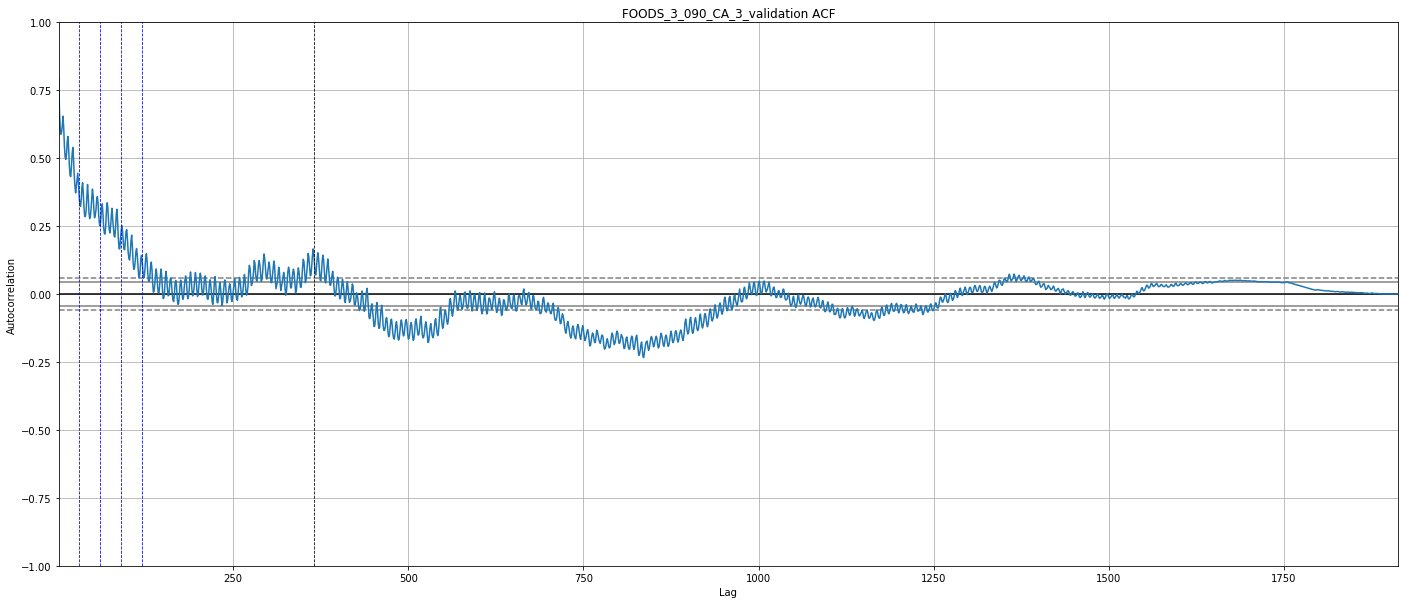

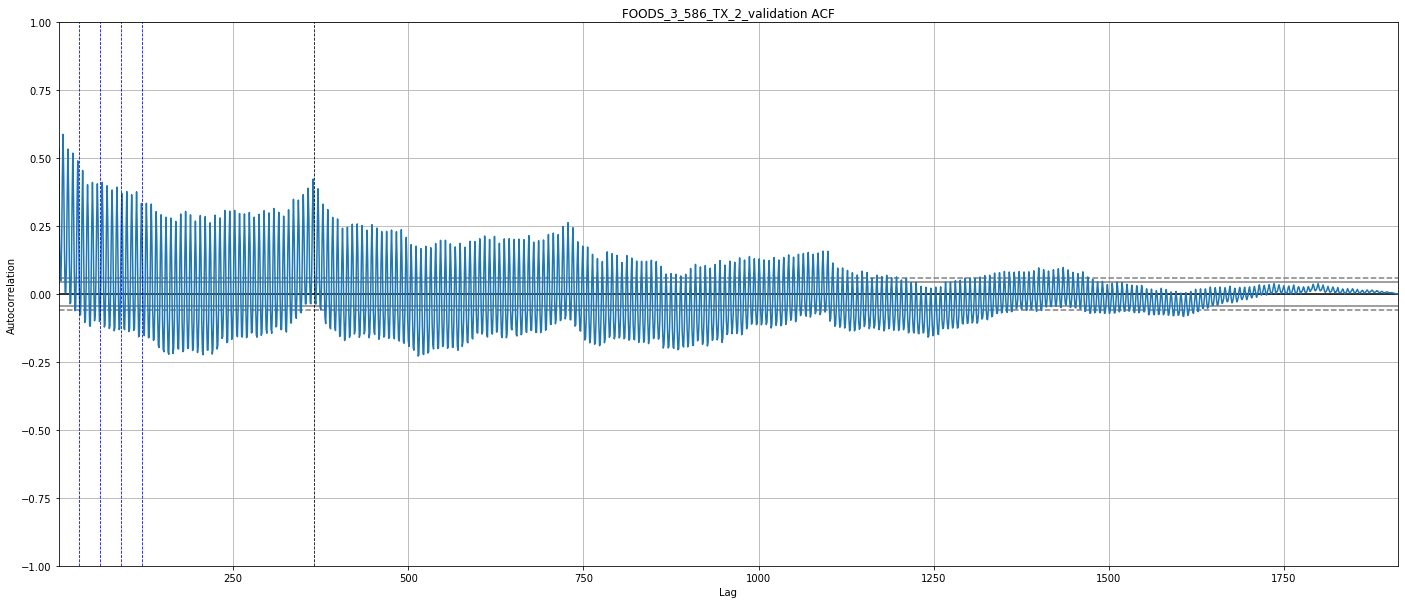

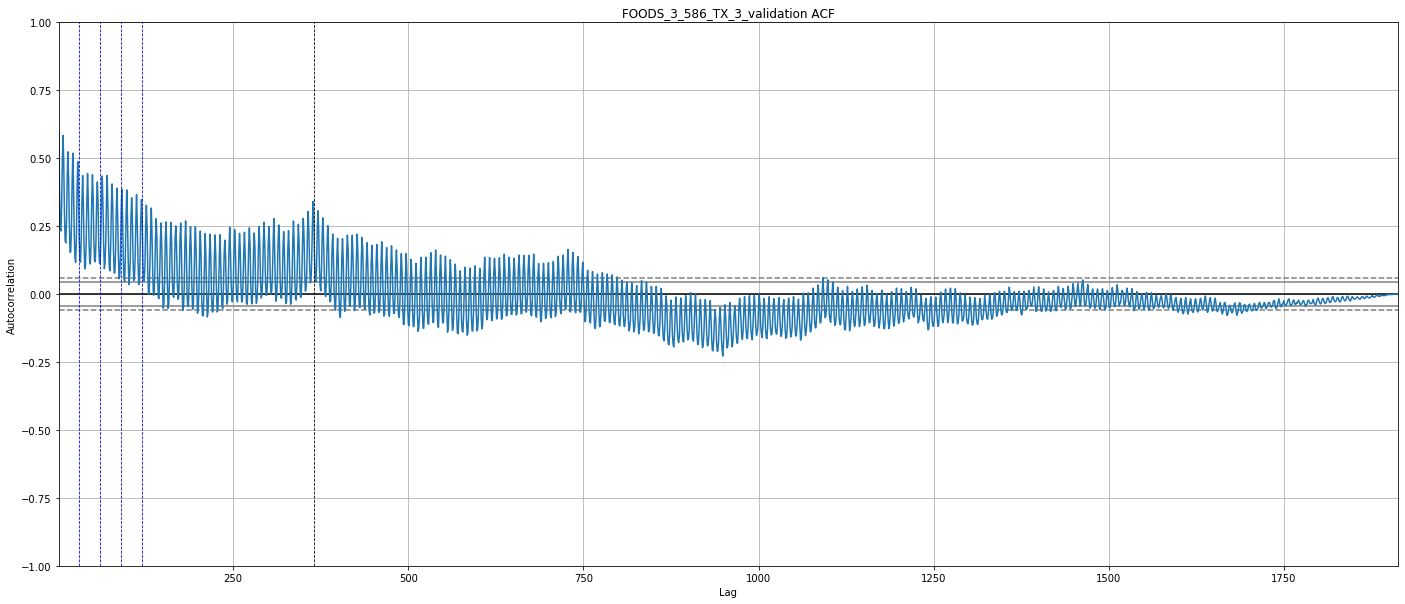

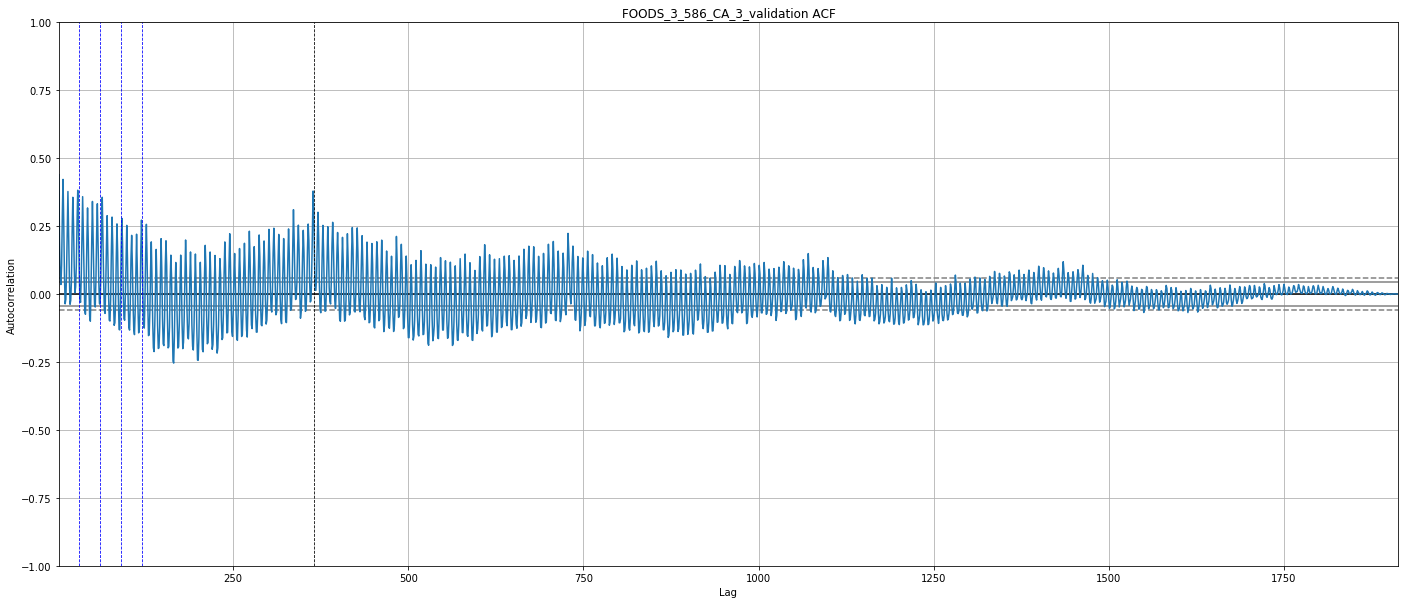

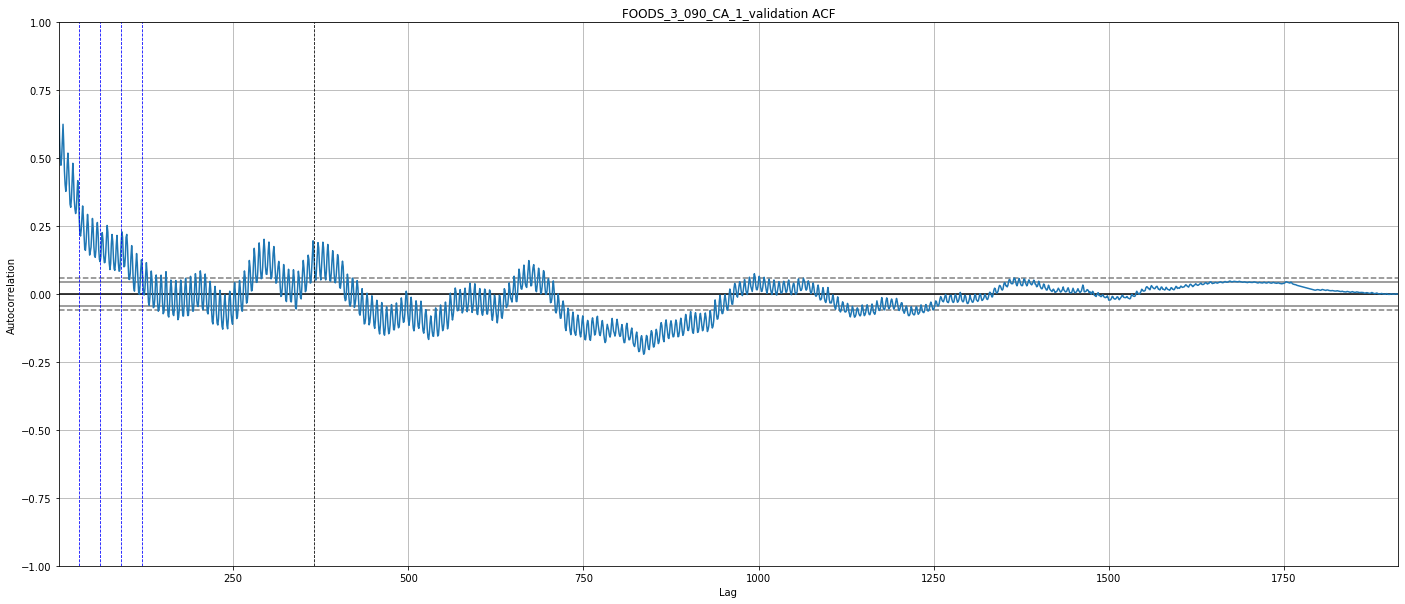

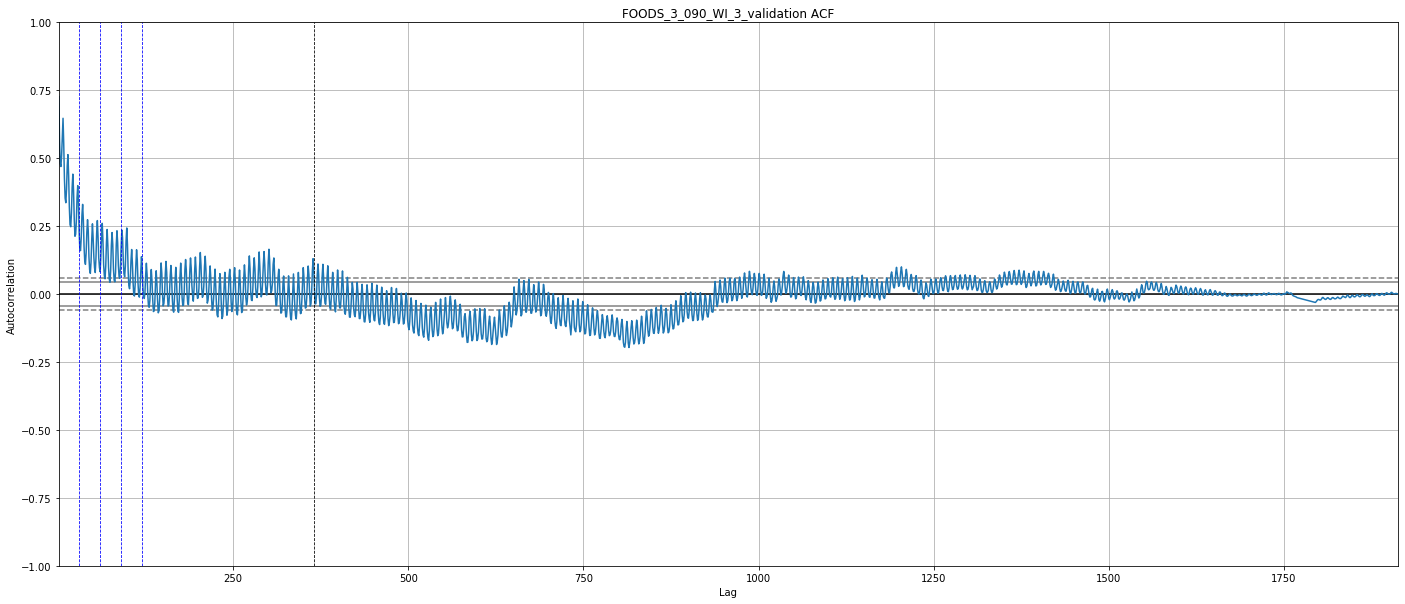

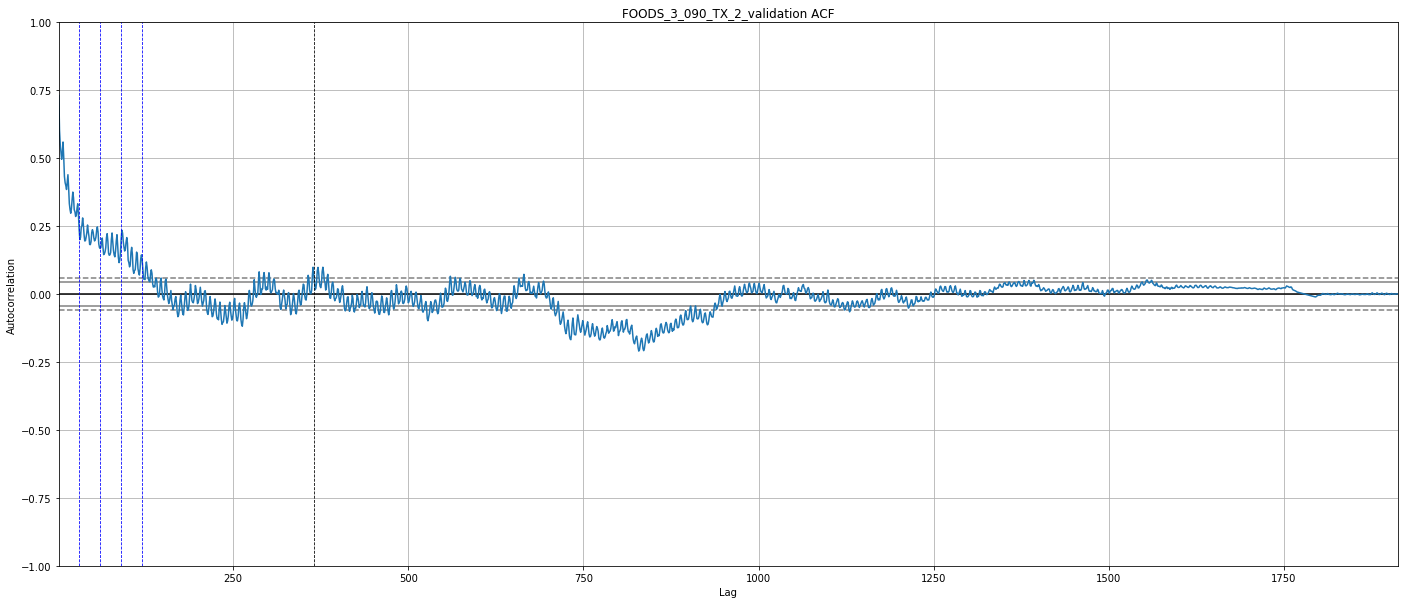

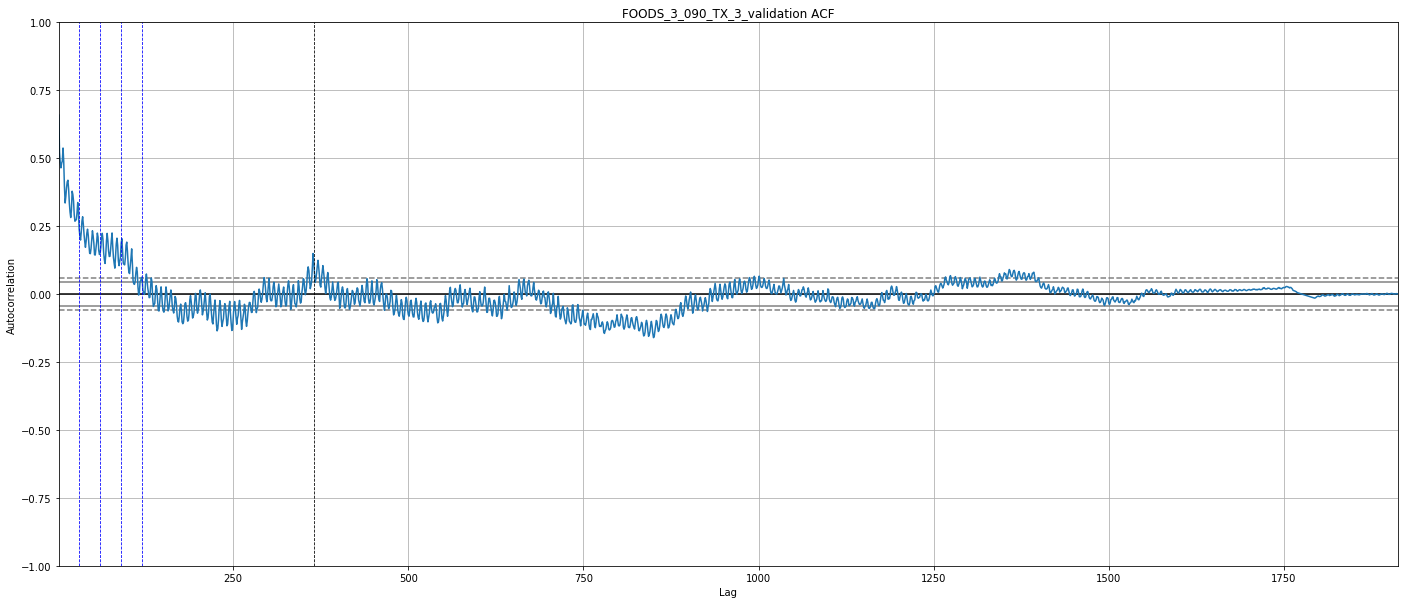

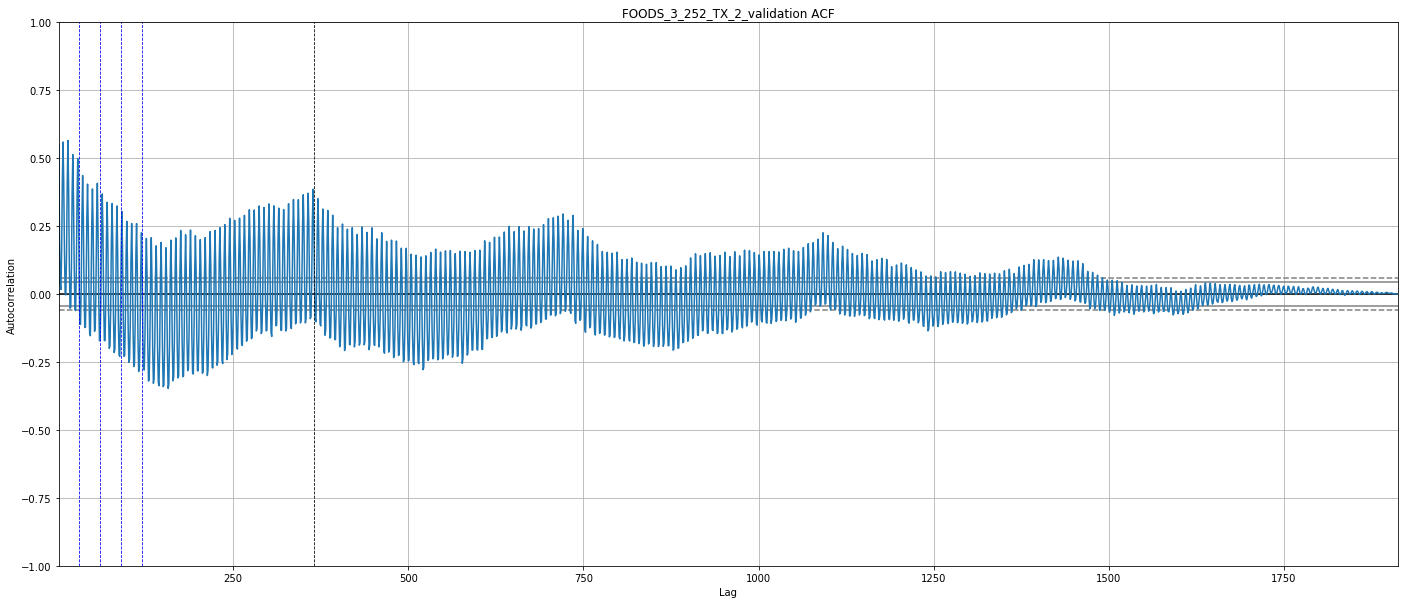

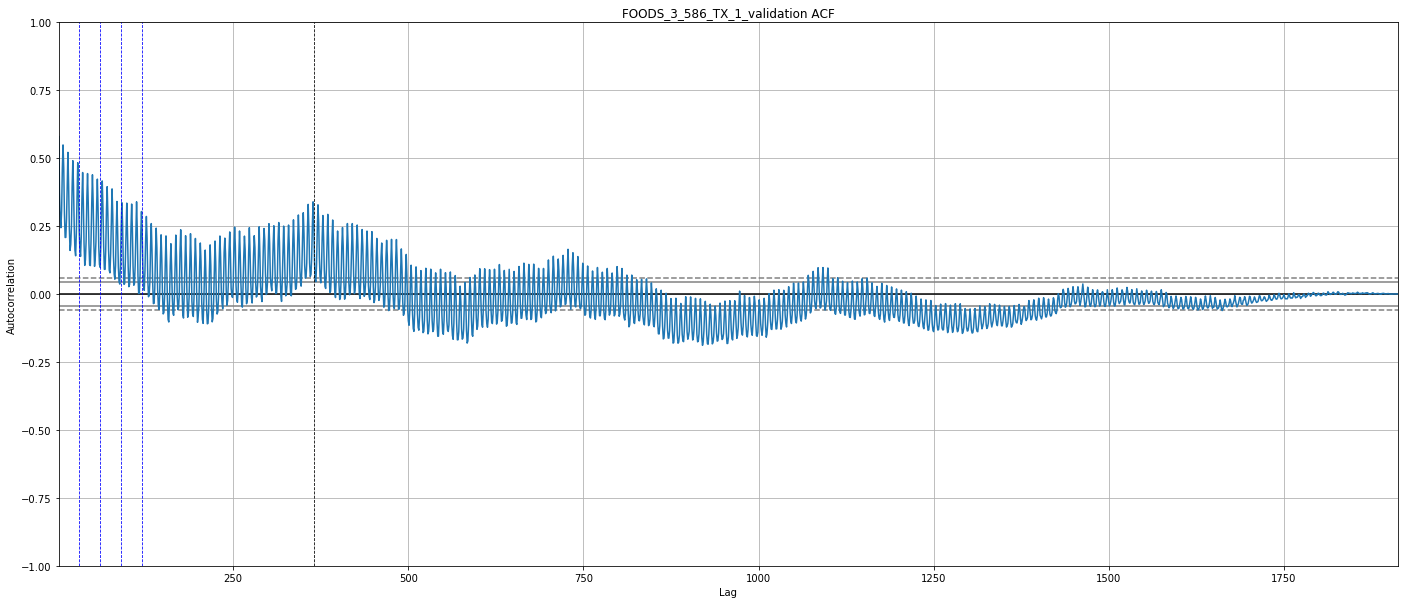

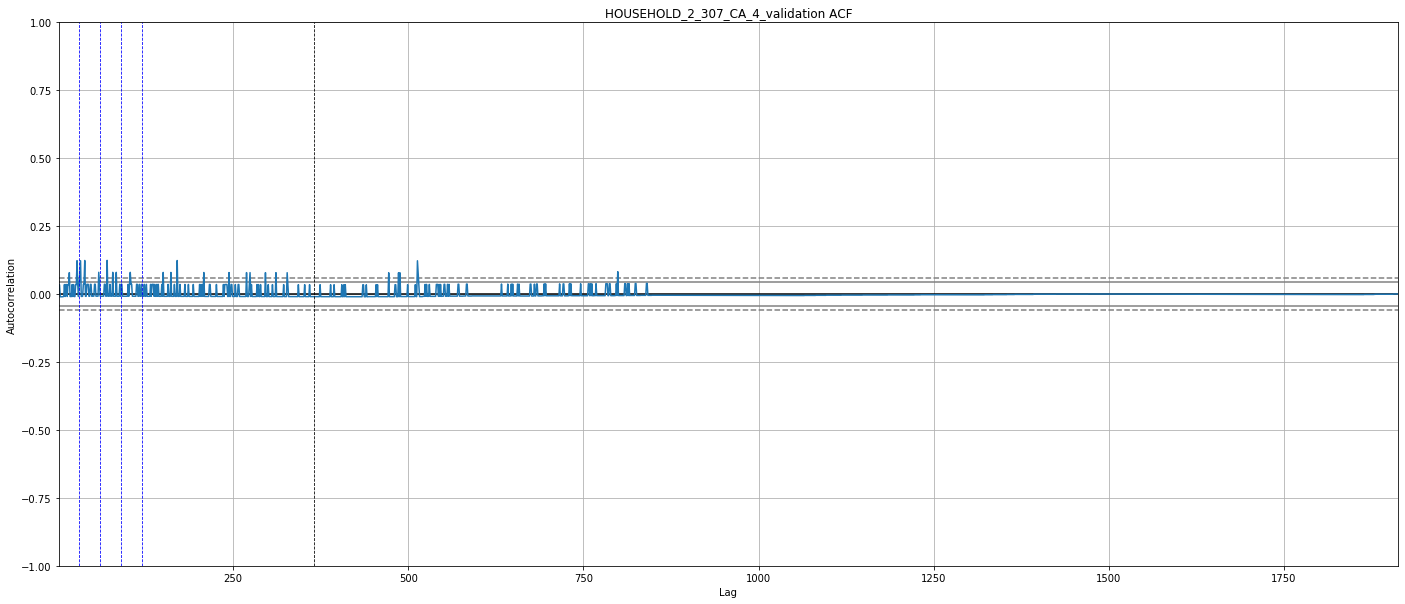

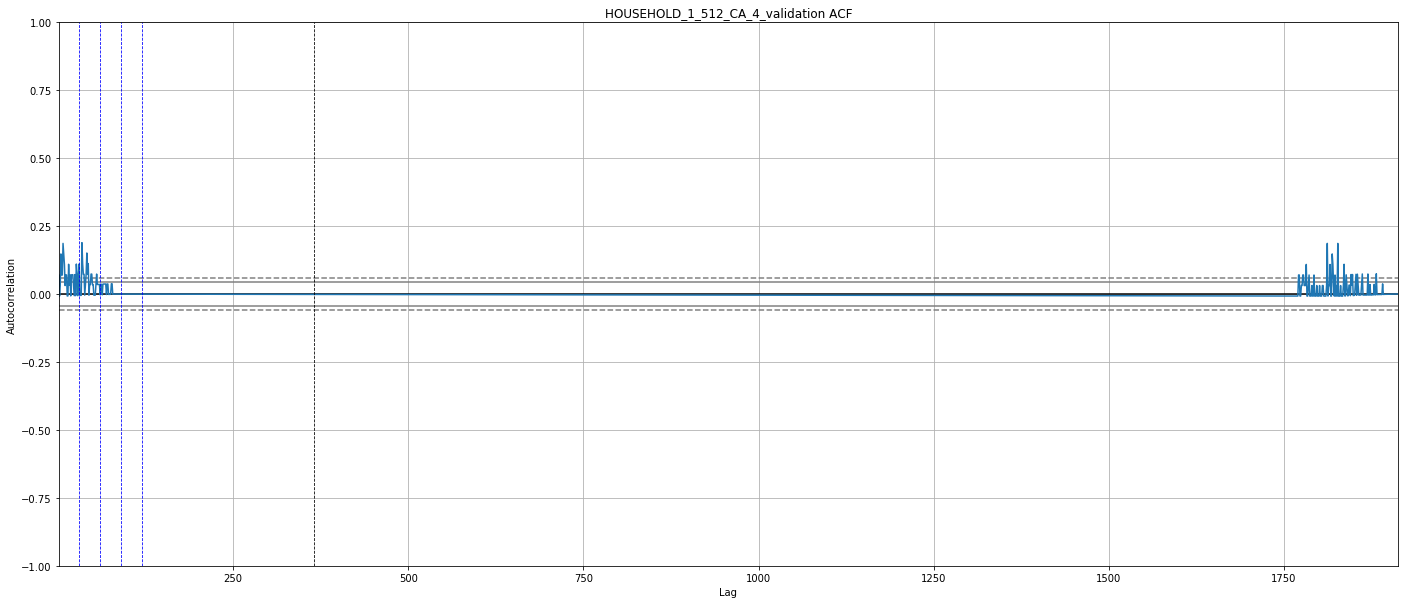

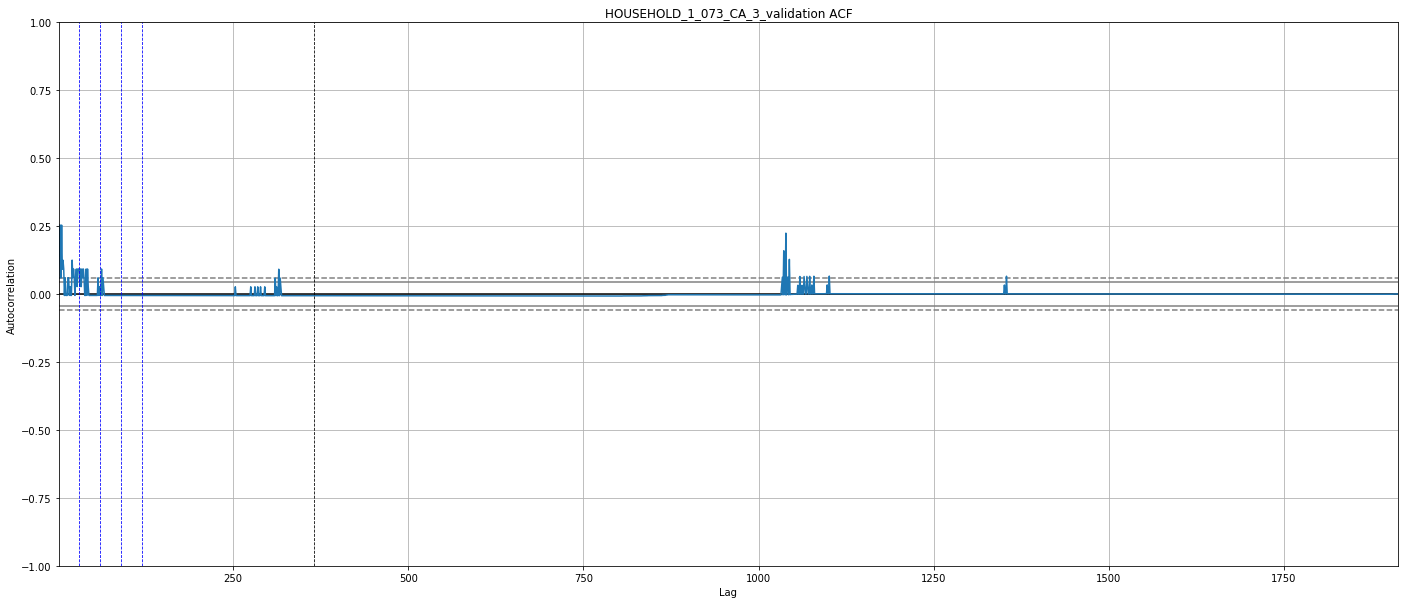

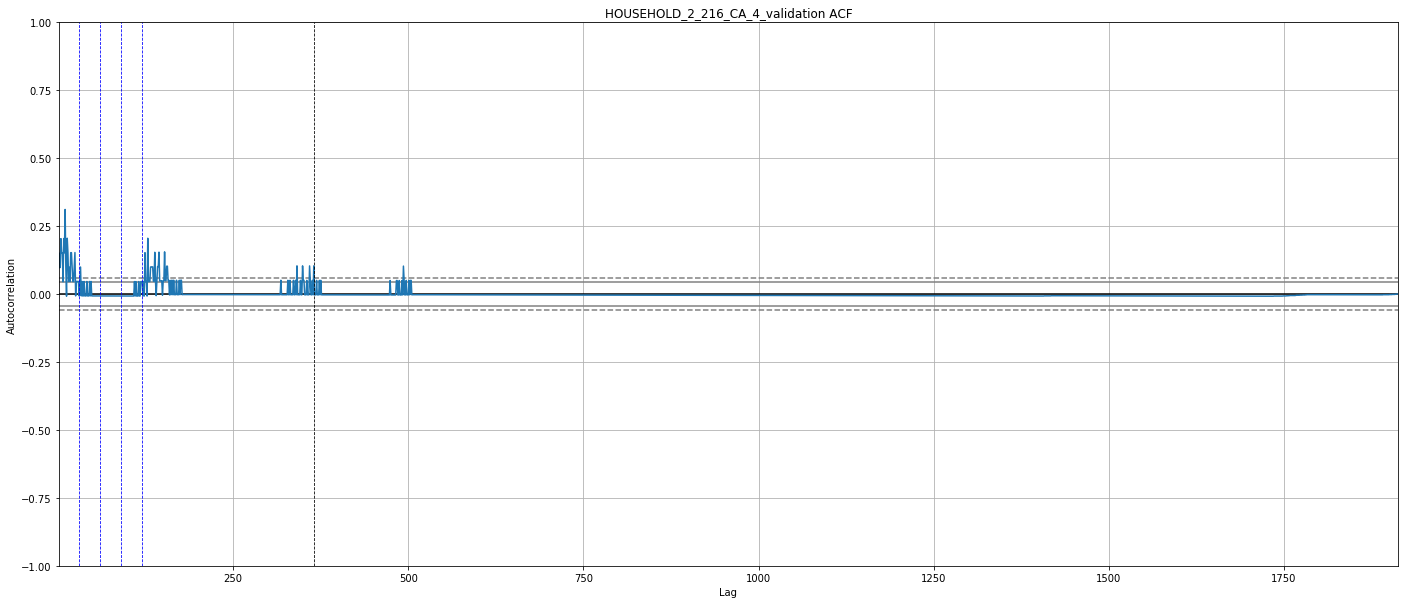

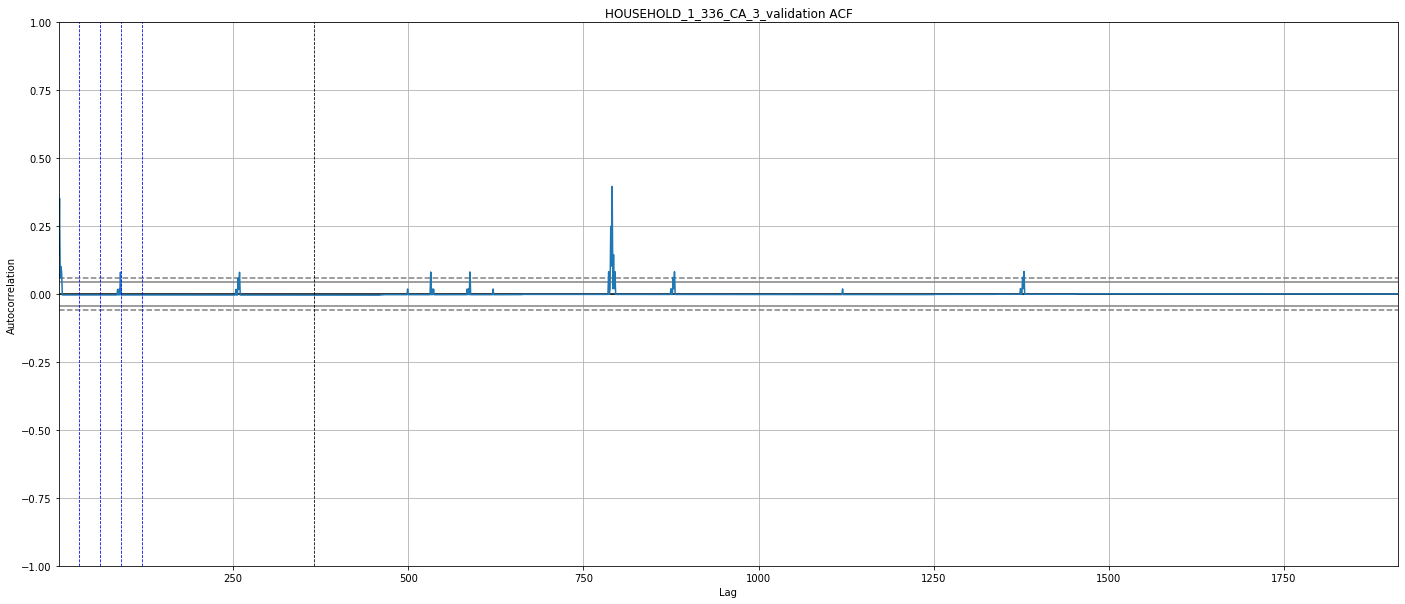

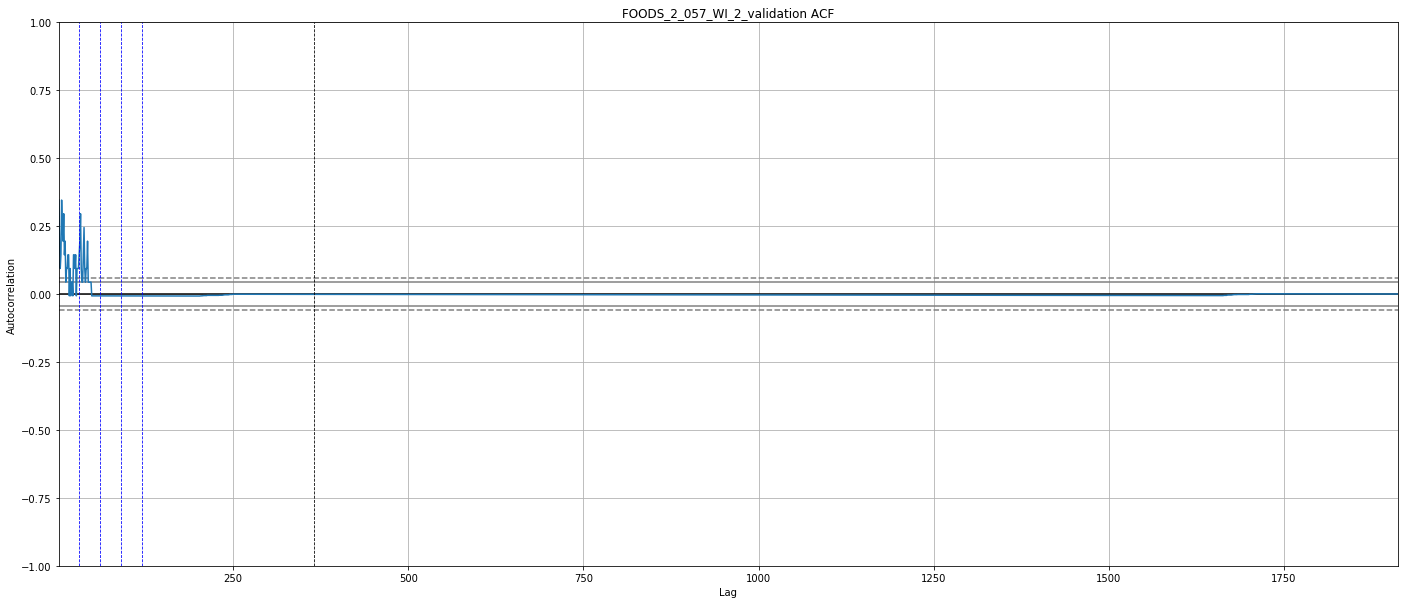

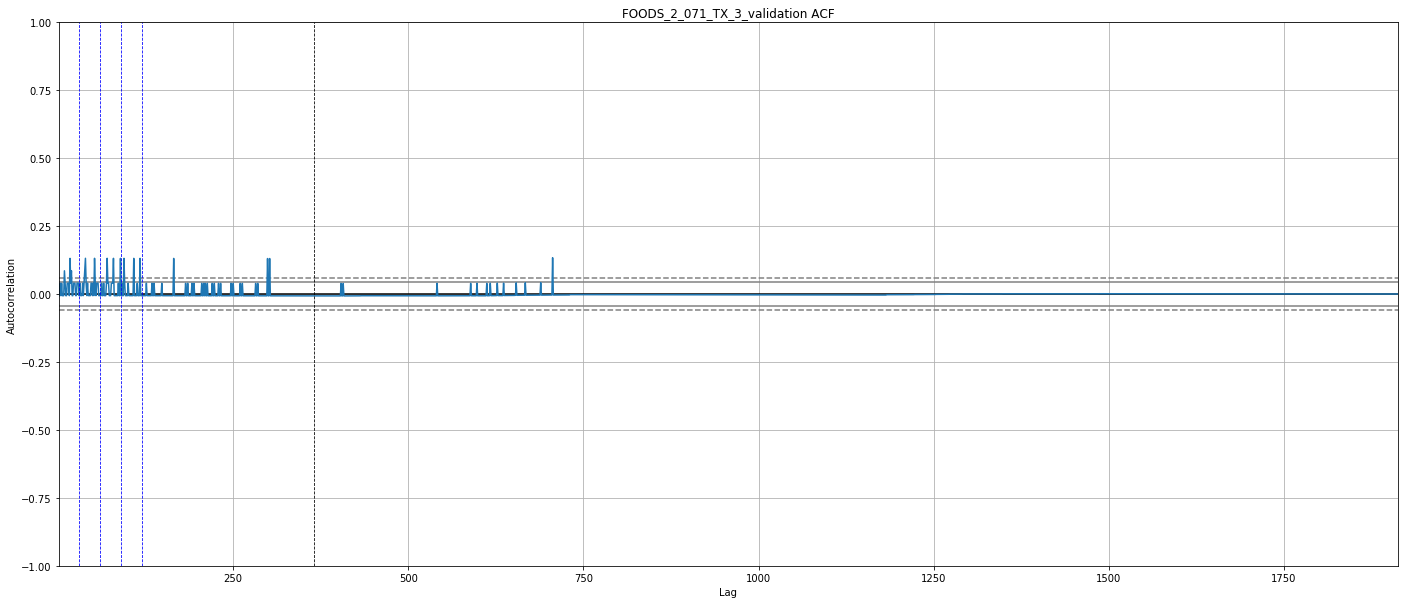

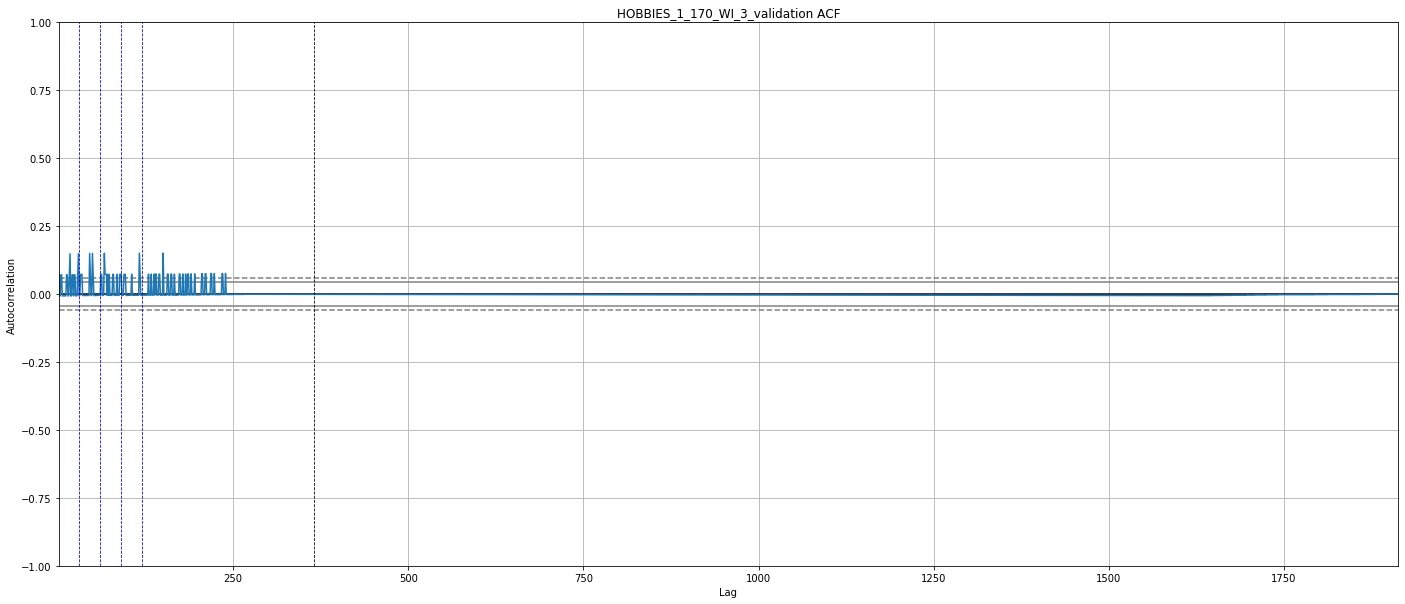

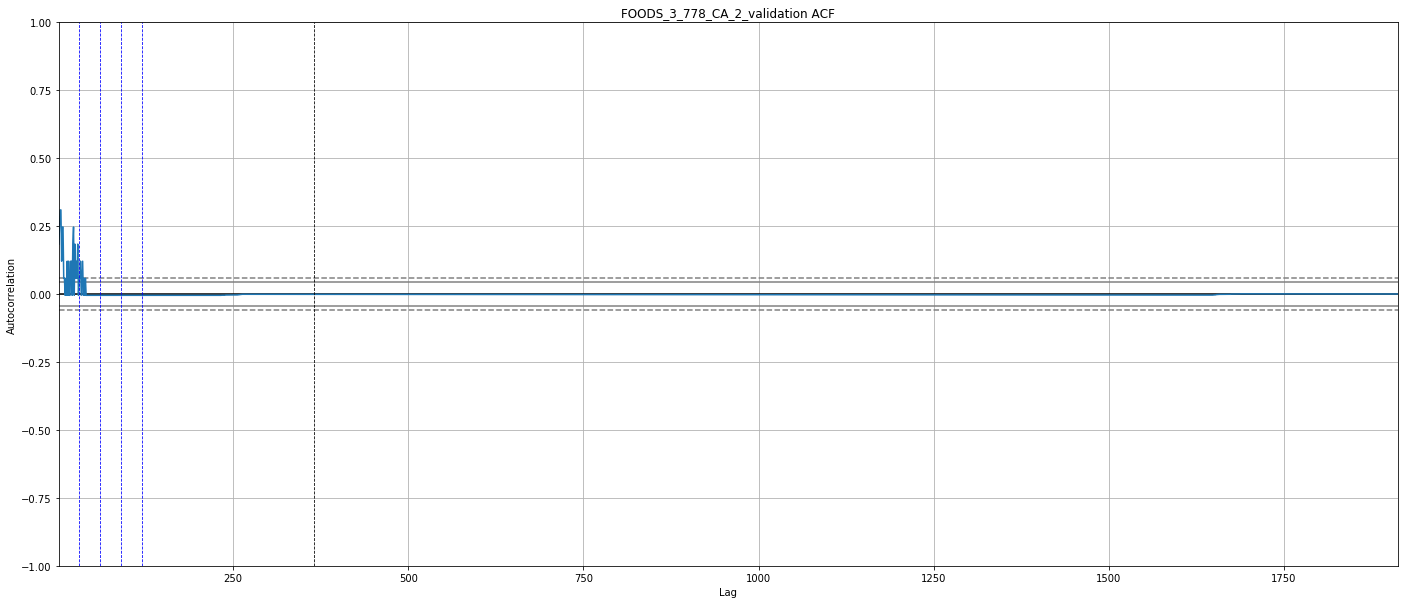

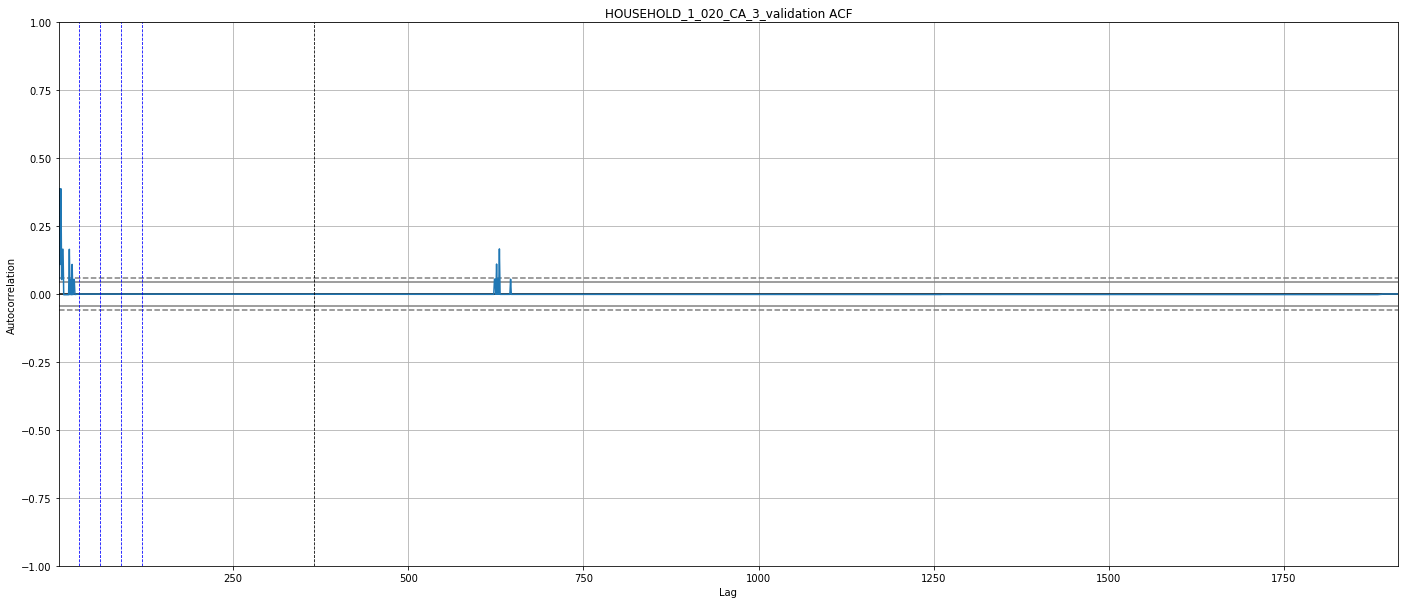

In [11]:
for product in top_10_products:
    make_acf(product)
for product in bottom_10_products:
    make_acf(product)

# PACF

In [12]:
def make_pacf(item):
    df_just_1 = df.loc[df['id'] == item]
    df_just_1.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace = True, axis = 1)
    
    melted_df = pd.melt(df_just_1, id_vars = 'id', var_name = 'date', value_name = 'quantity_purchased')
    melted_df.drop(['id'], axis = 1, inplace = True)
    
    together_now = pd.merge(melted_df, df_cal, left_on = 'date', right_on = 'd', how = 'inner')
    together_now.drop(['date_x', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 1, inplace = True)
    together_now.set_index('date_y', inplace = True)

    
    rcParams['figure.figsize'] = 24, 10
    plot_pacf(together_now, lags=30)
    plt.title('PACF for {}'.format(item))

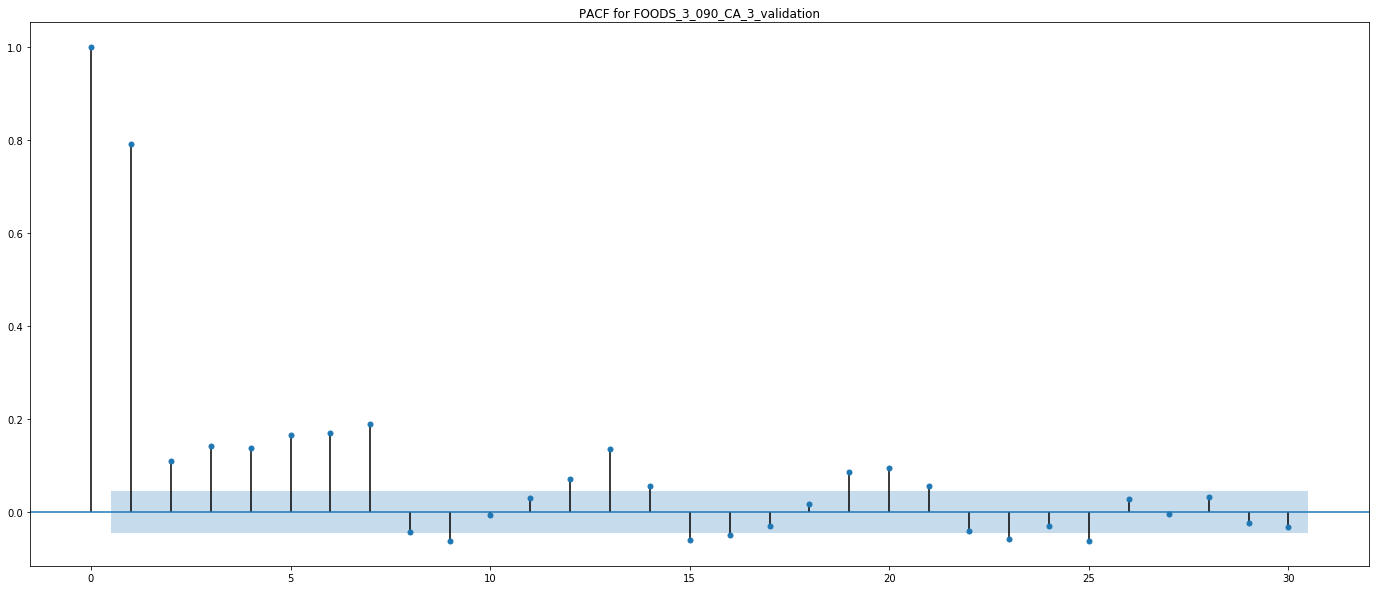

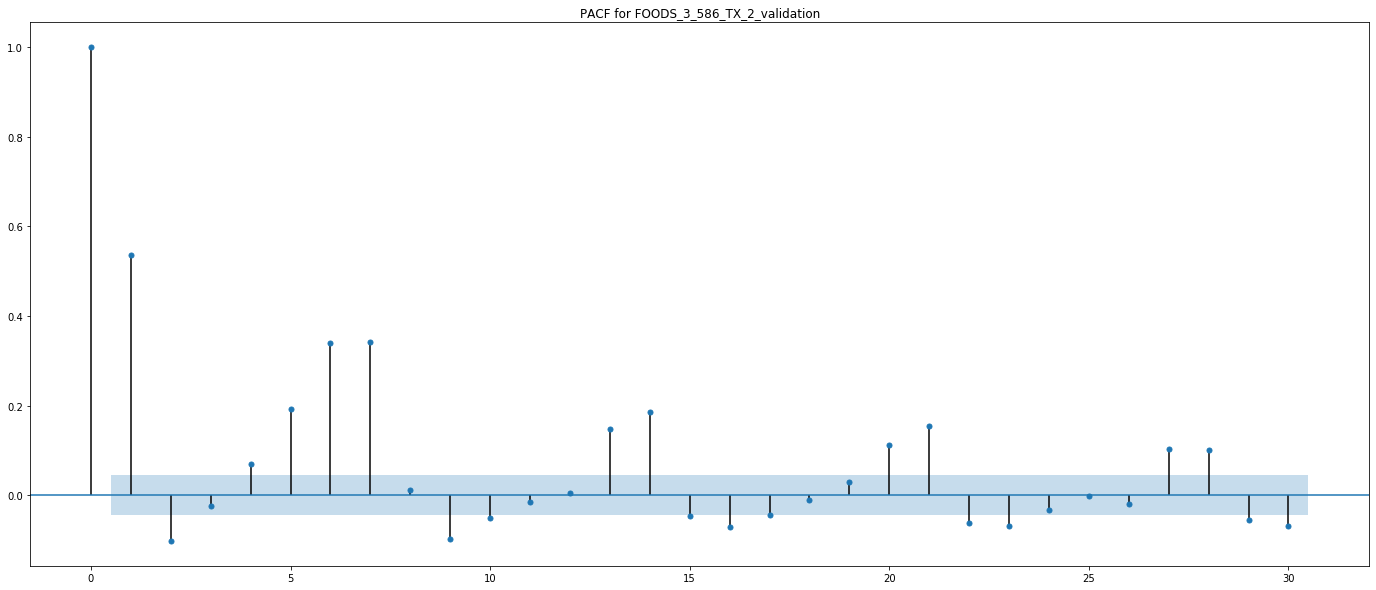

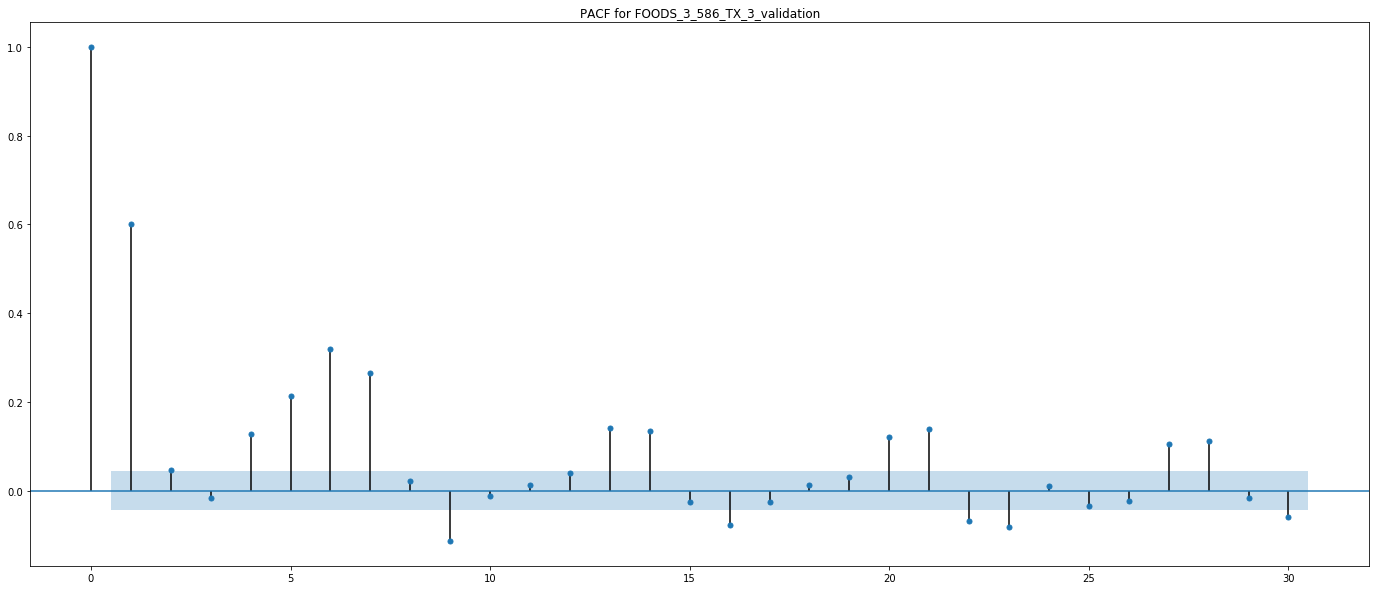

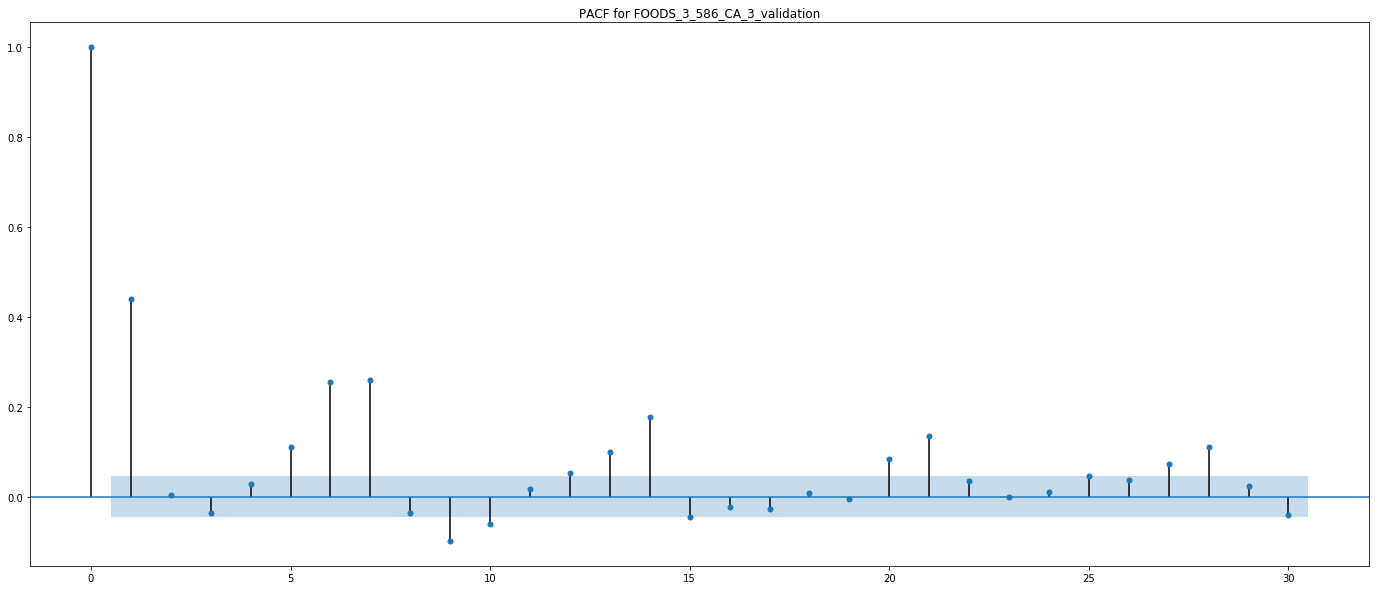

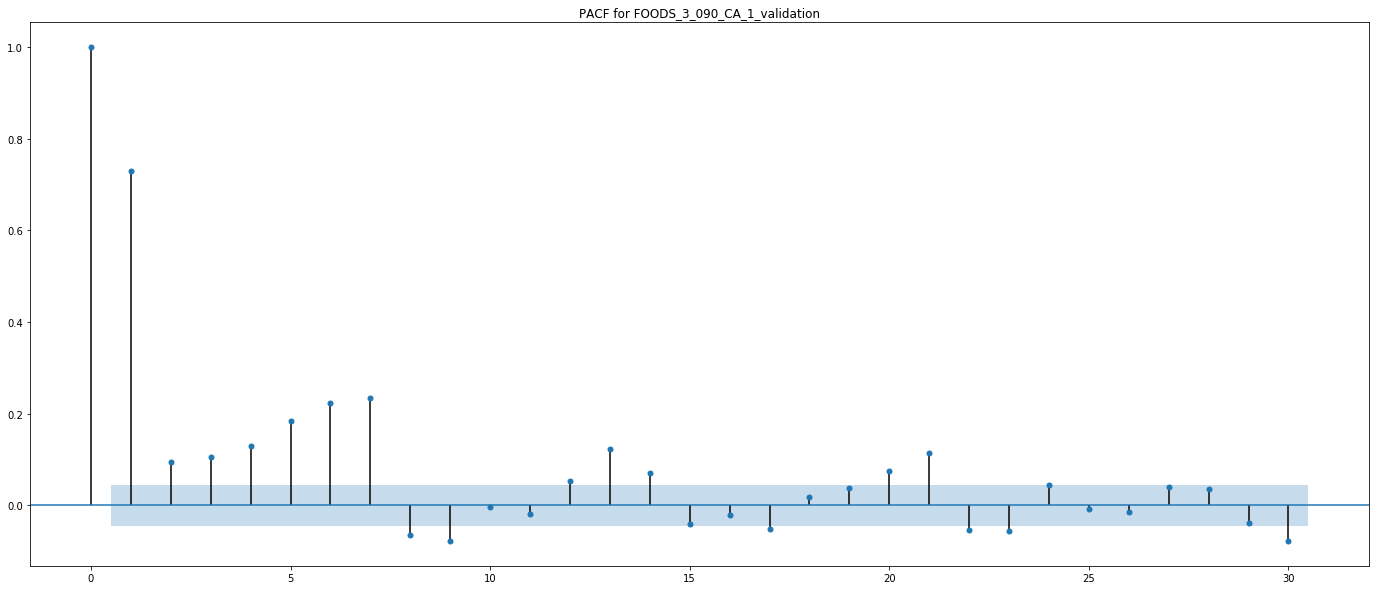

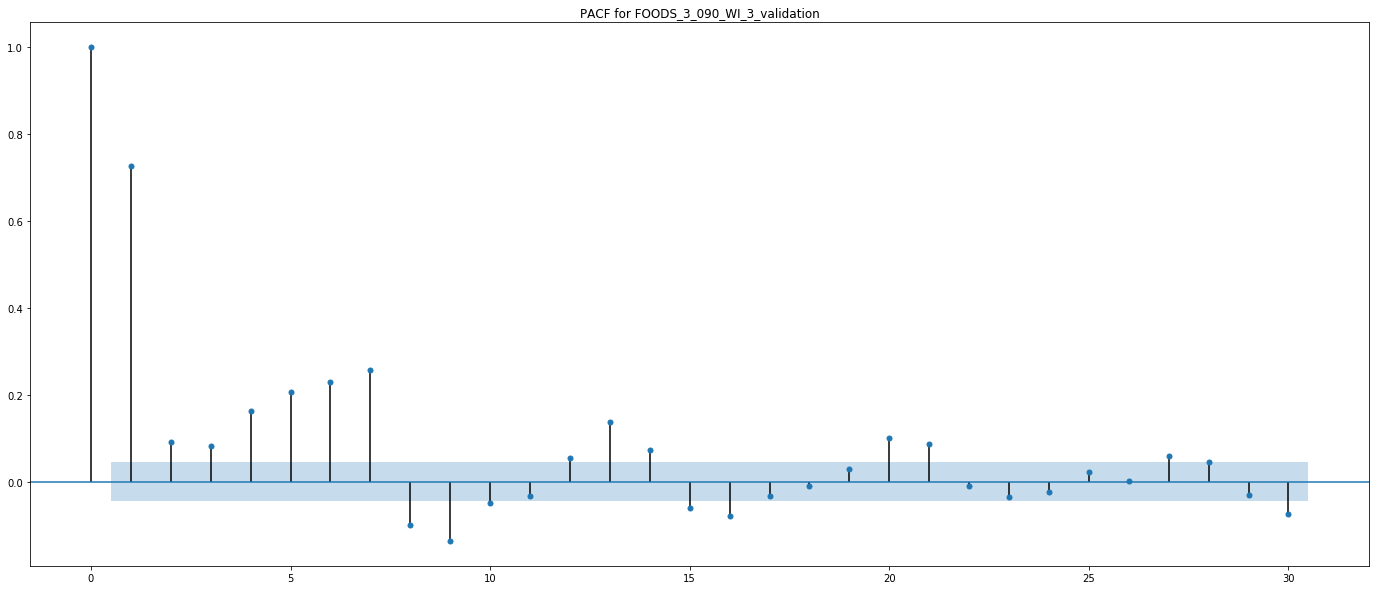

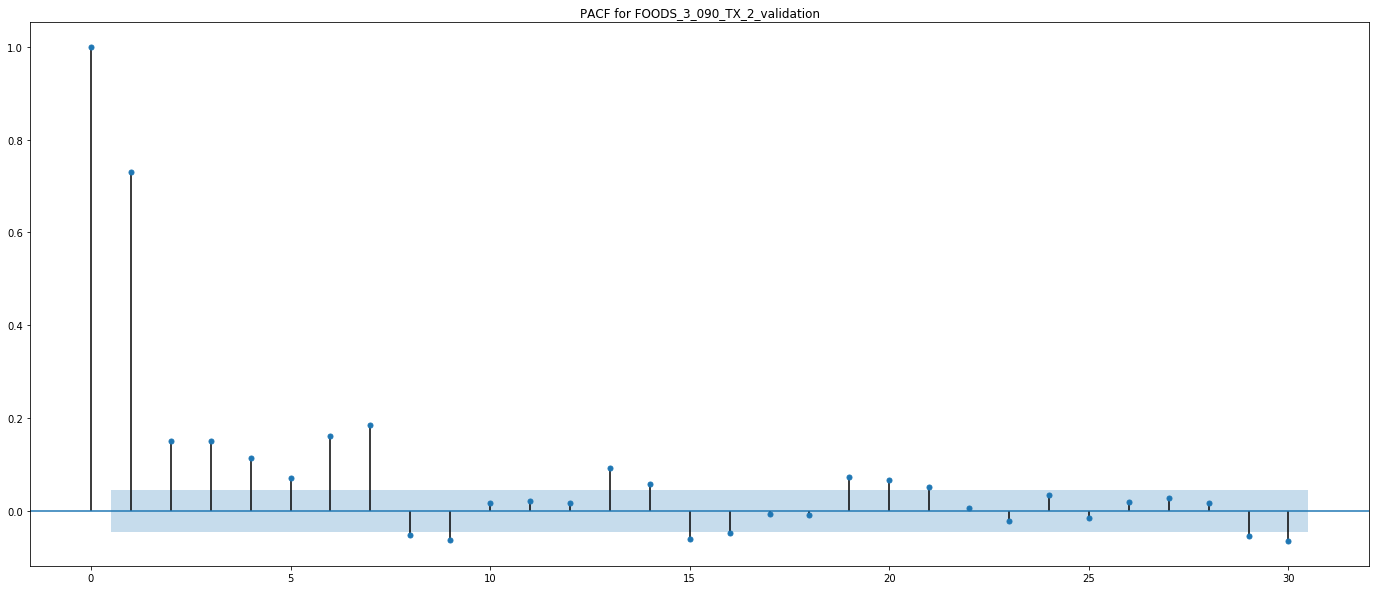

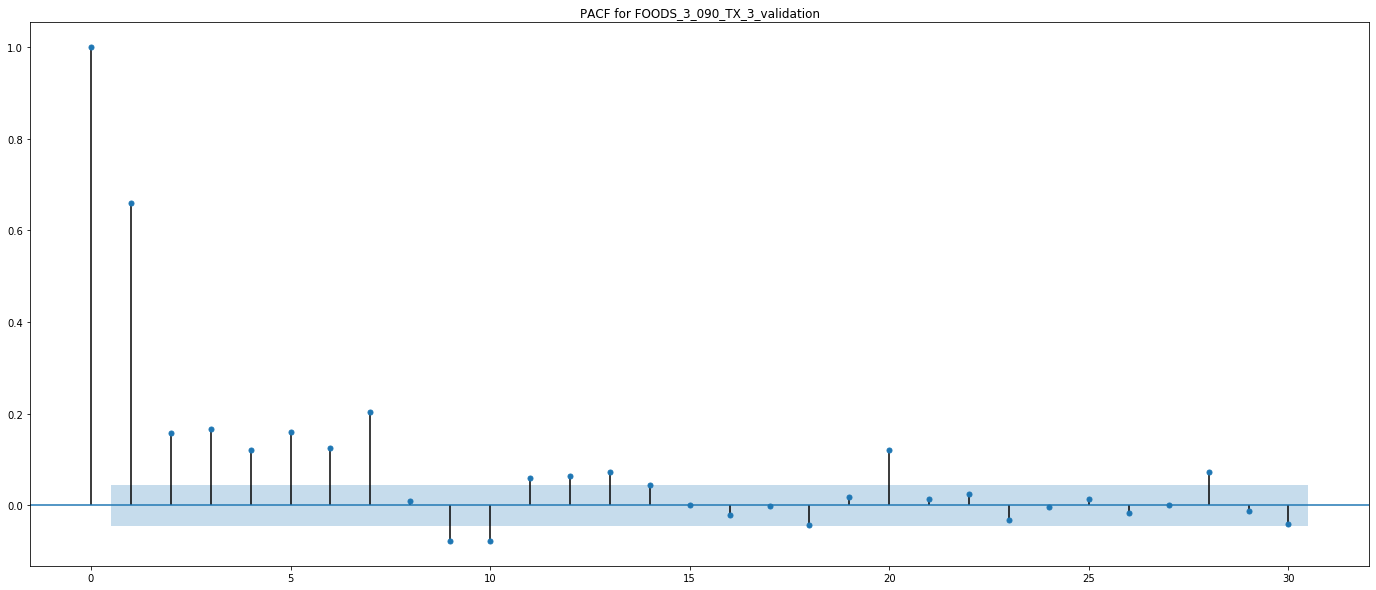

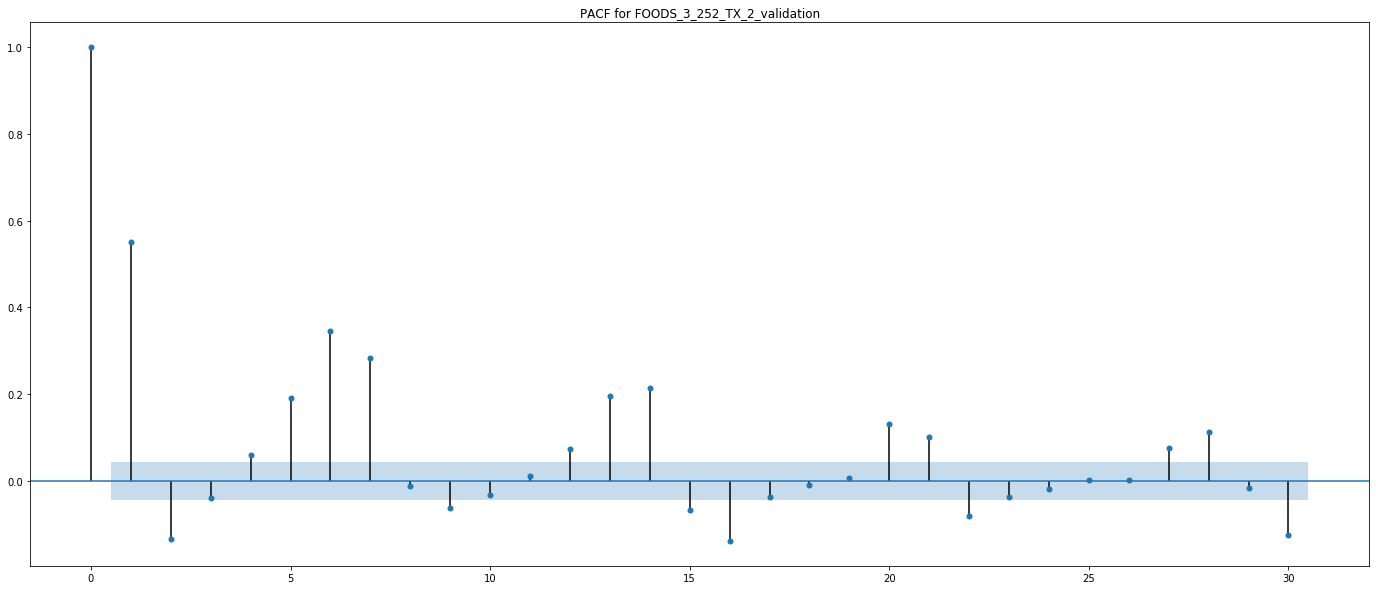

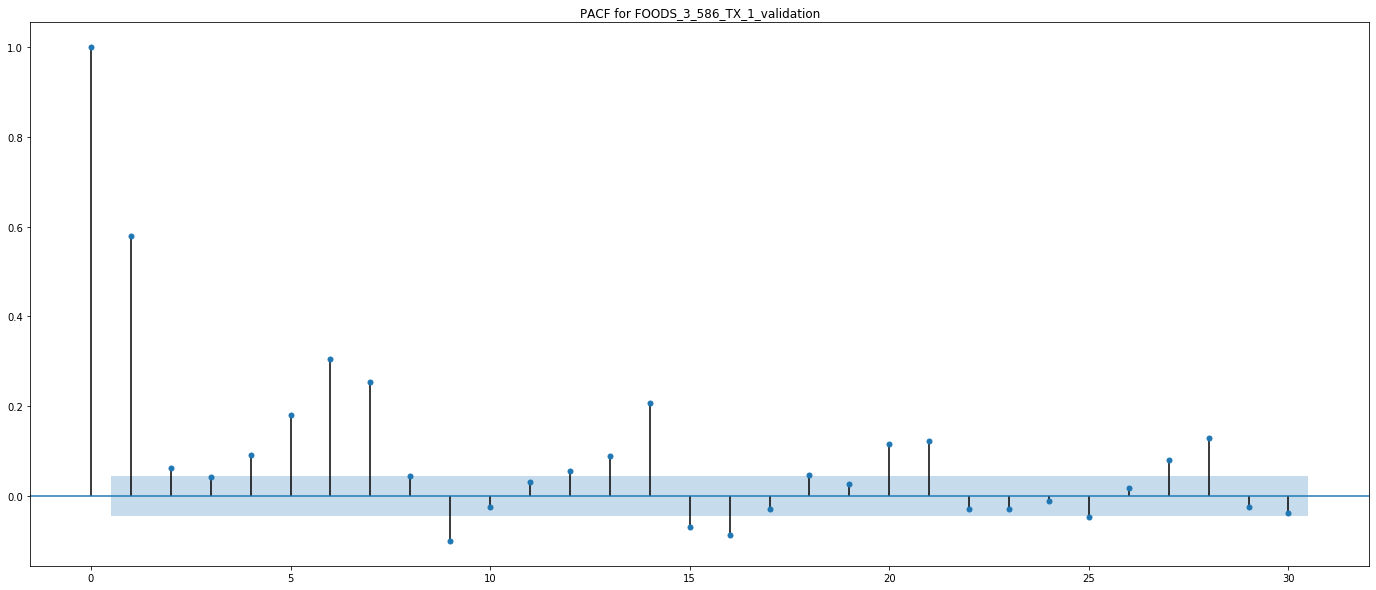

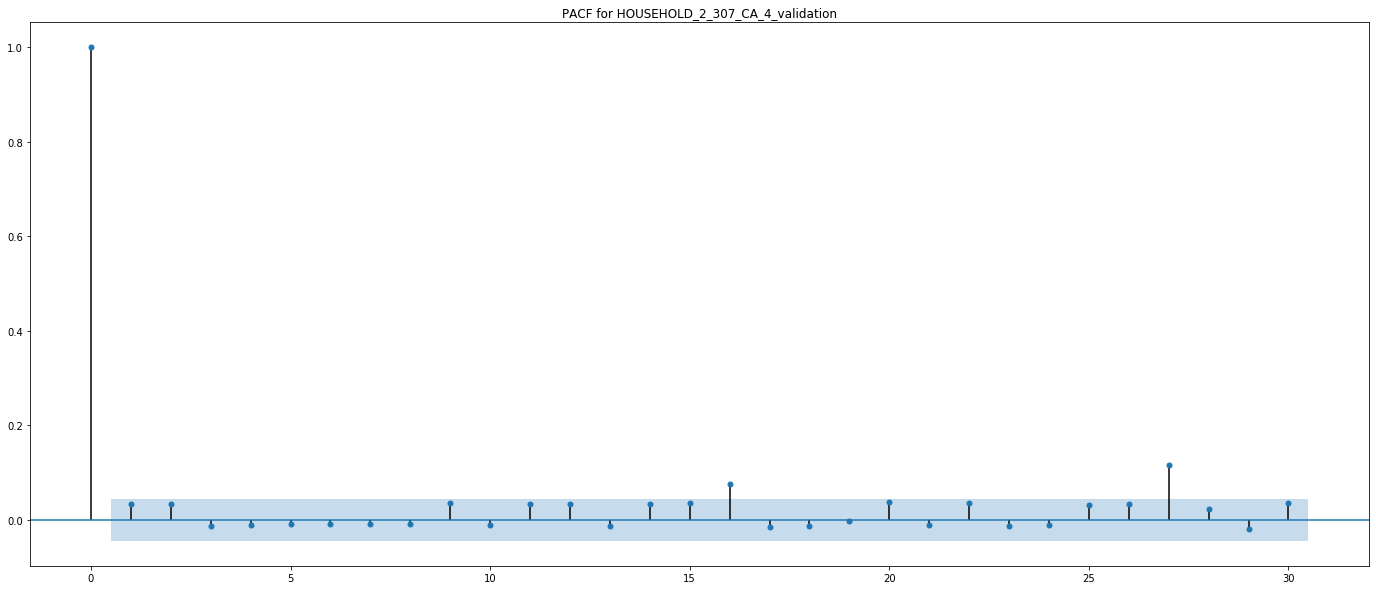

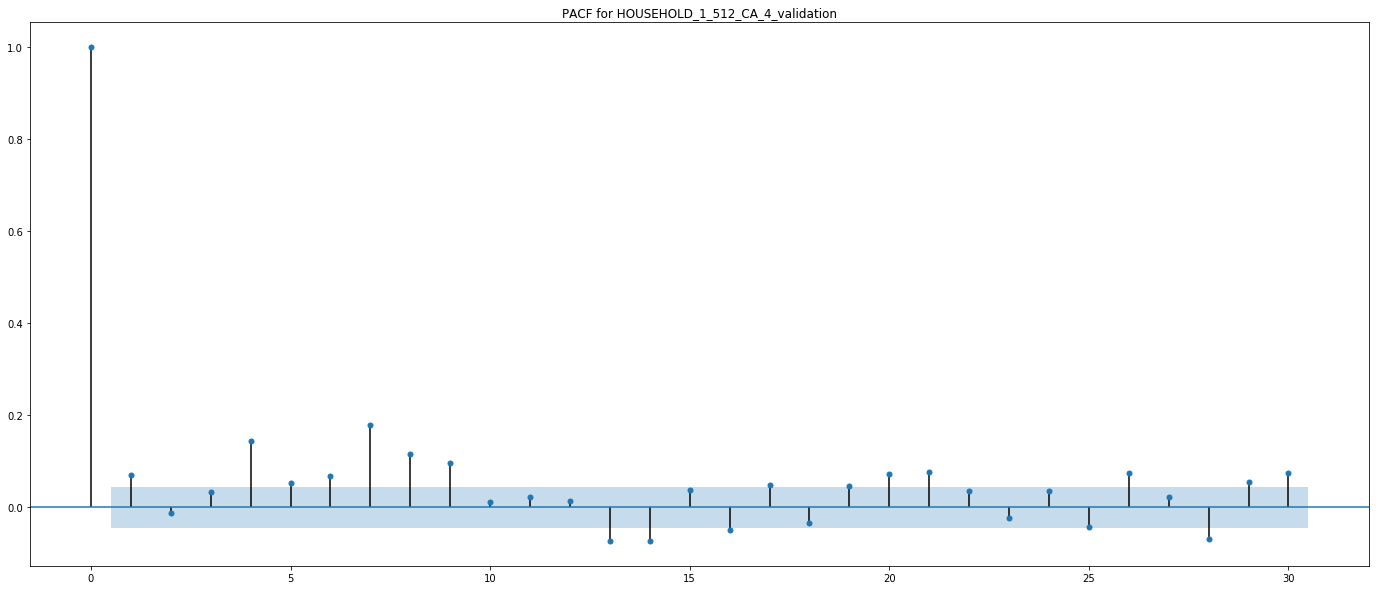

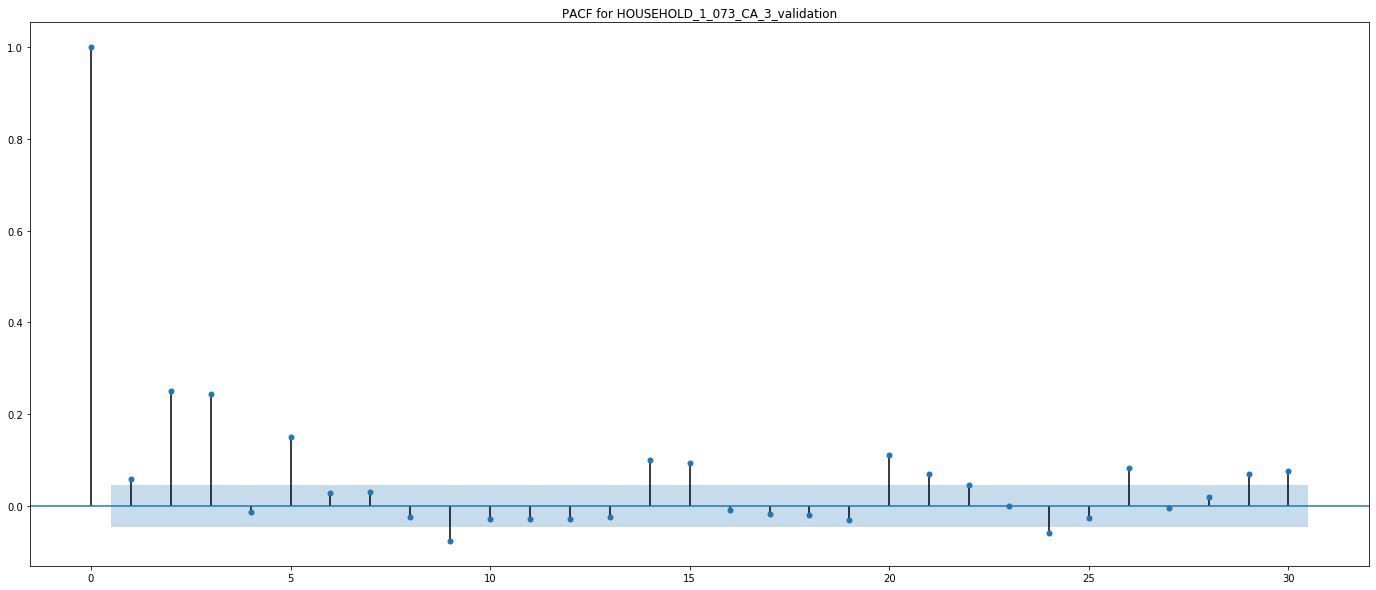

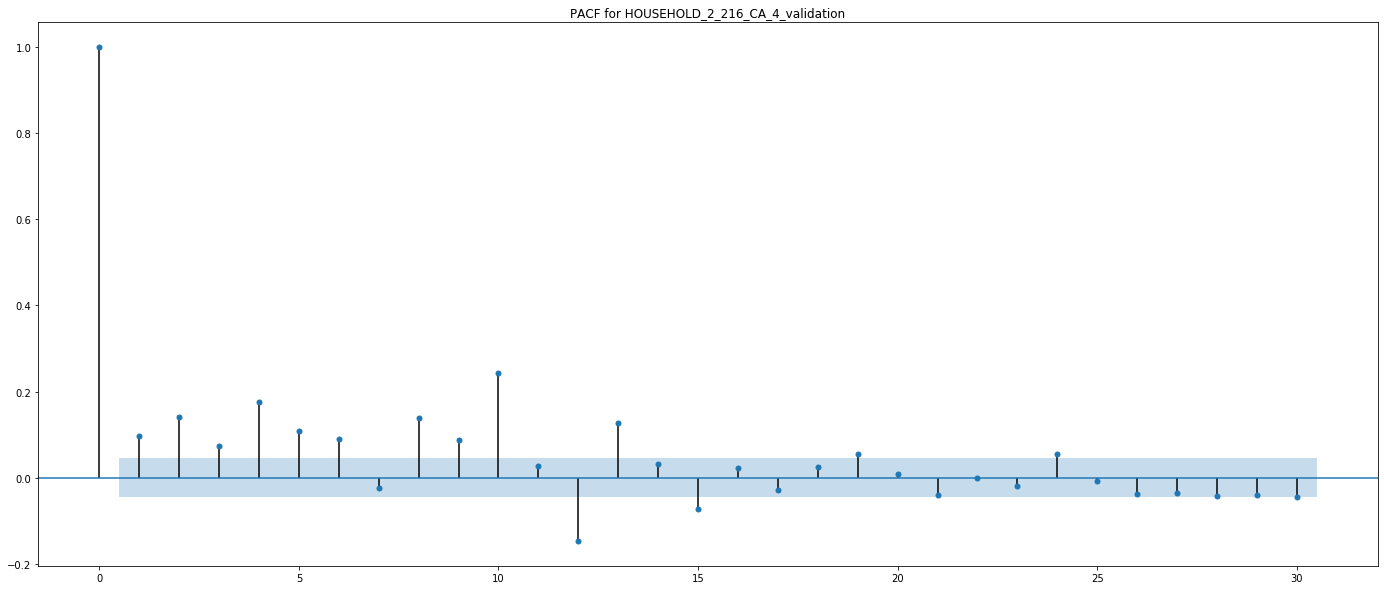

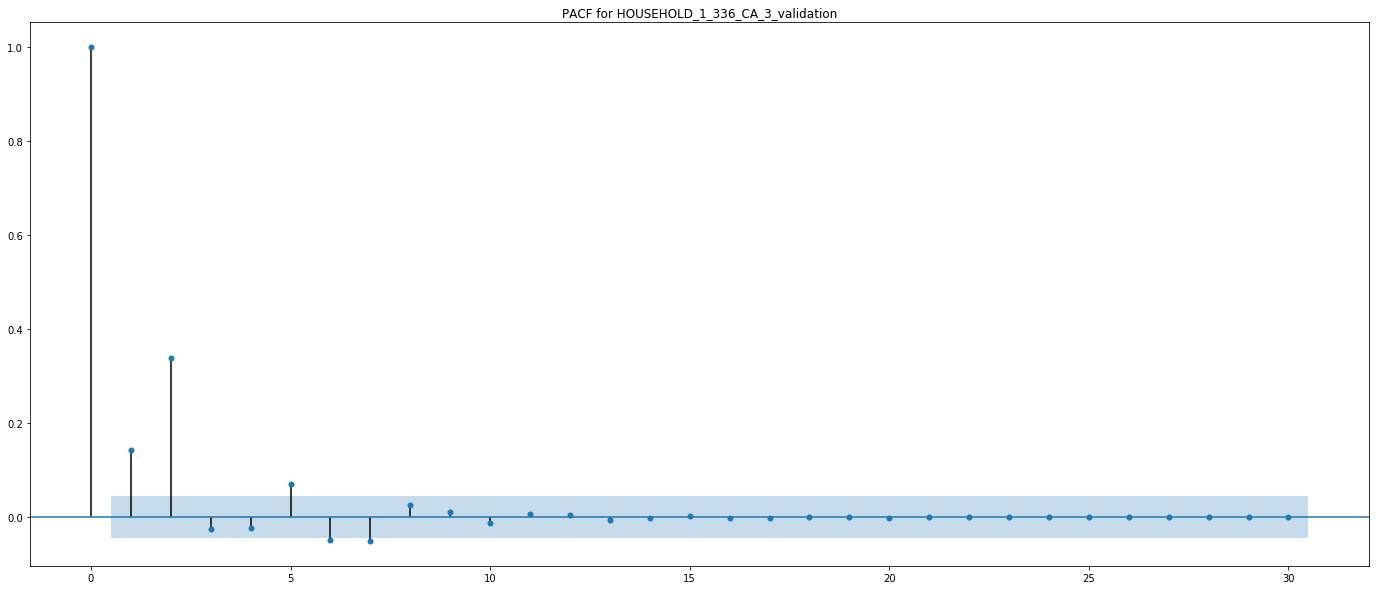

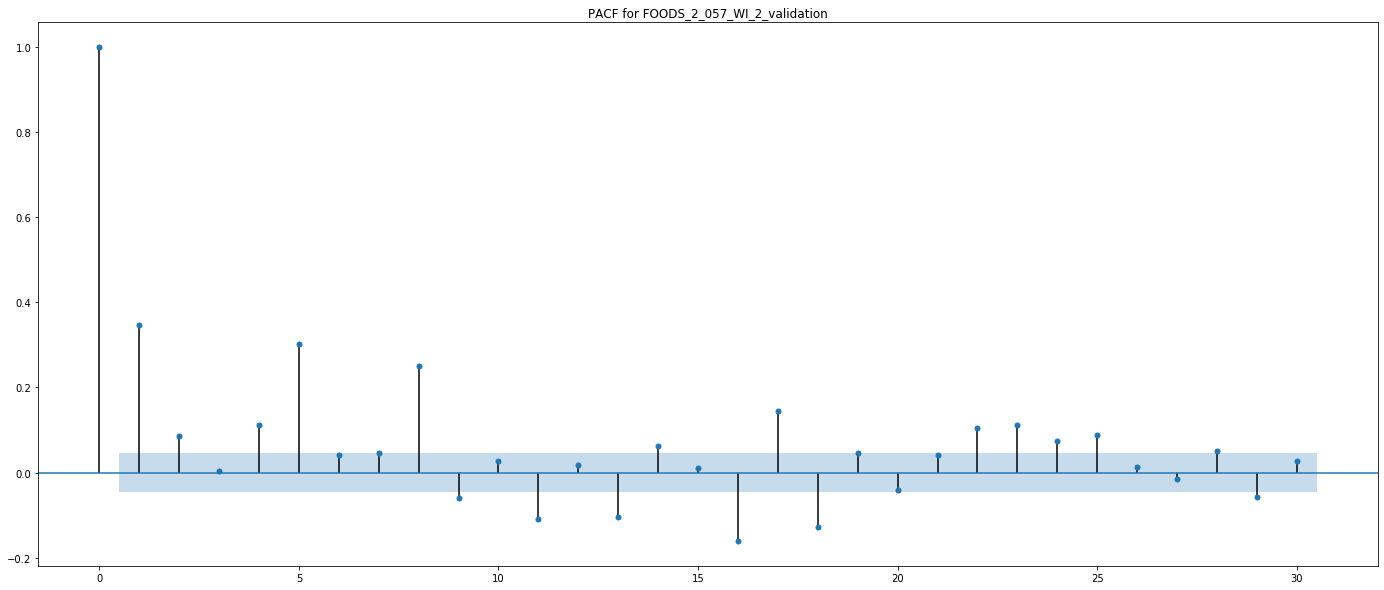

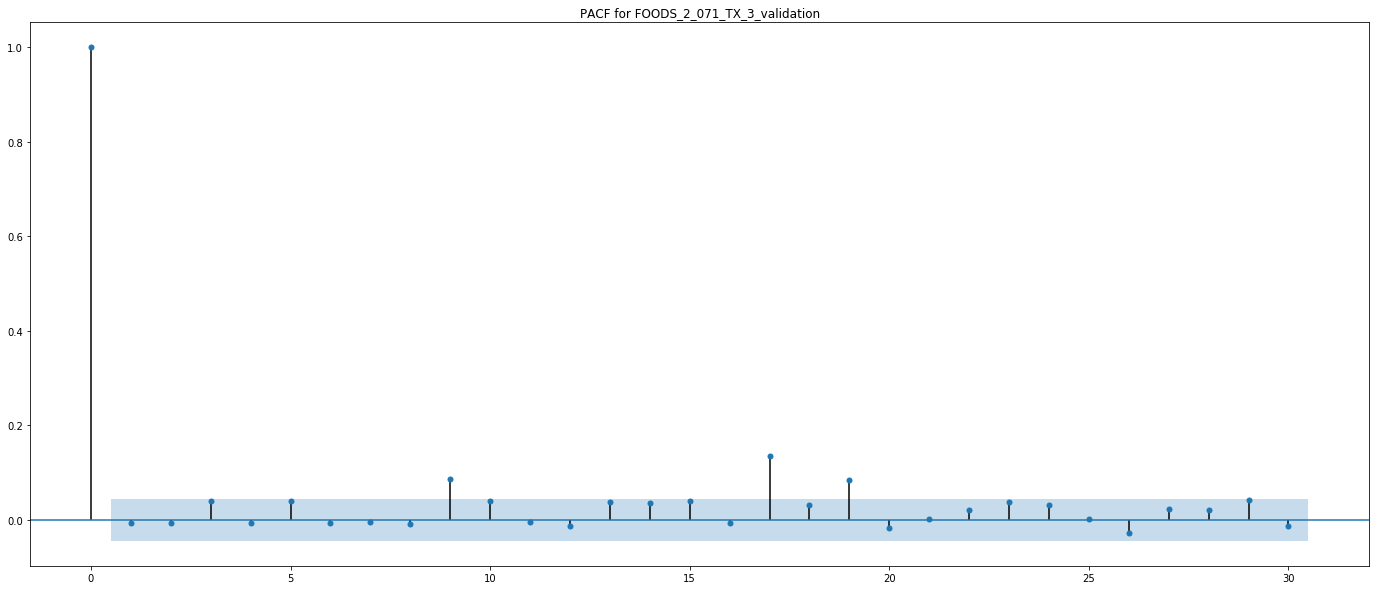

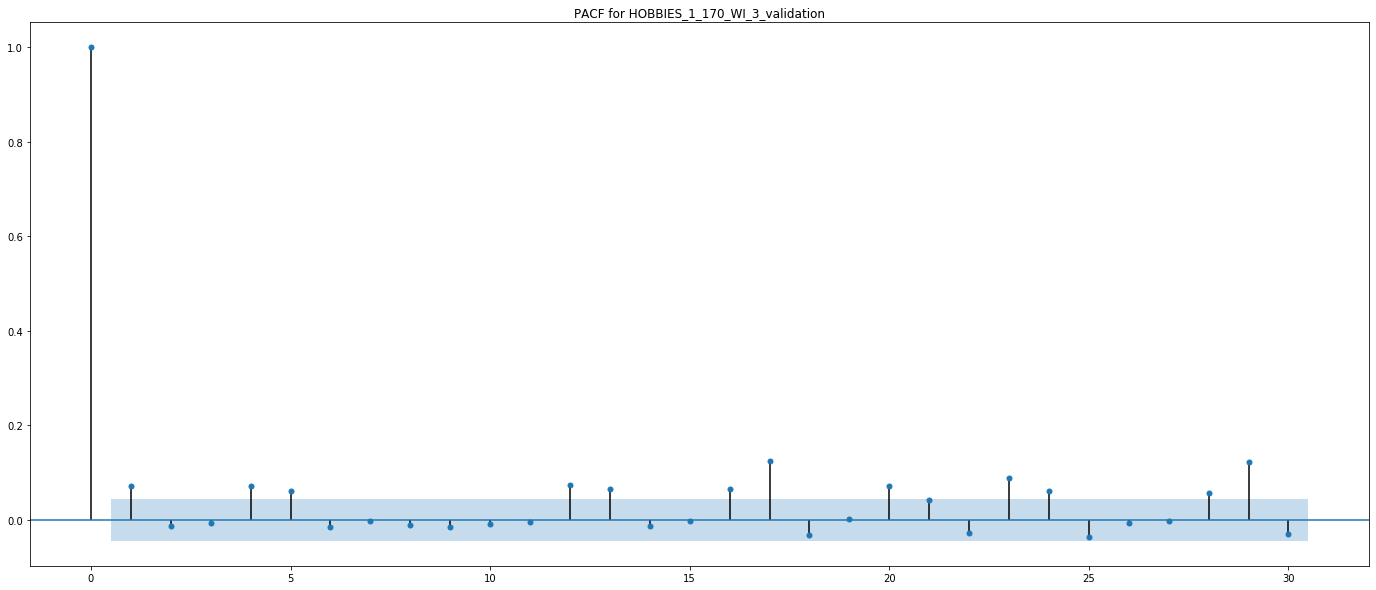

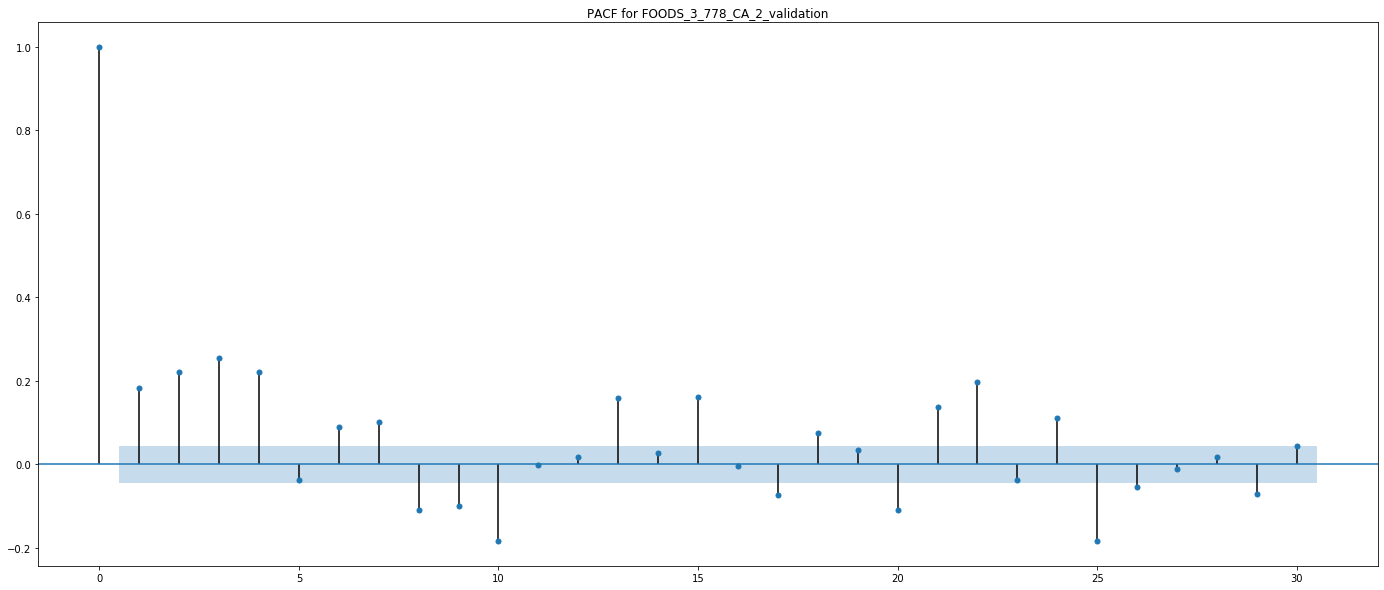

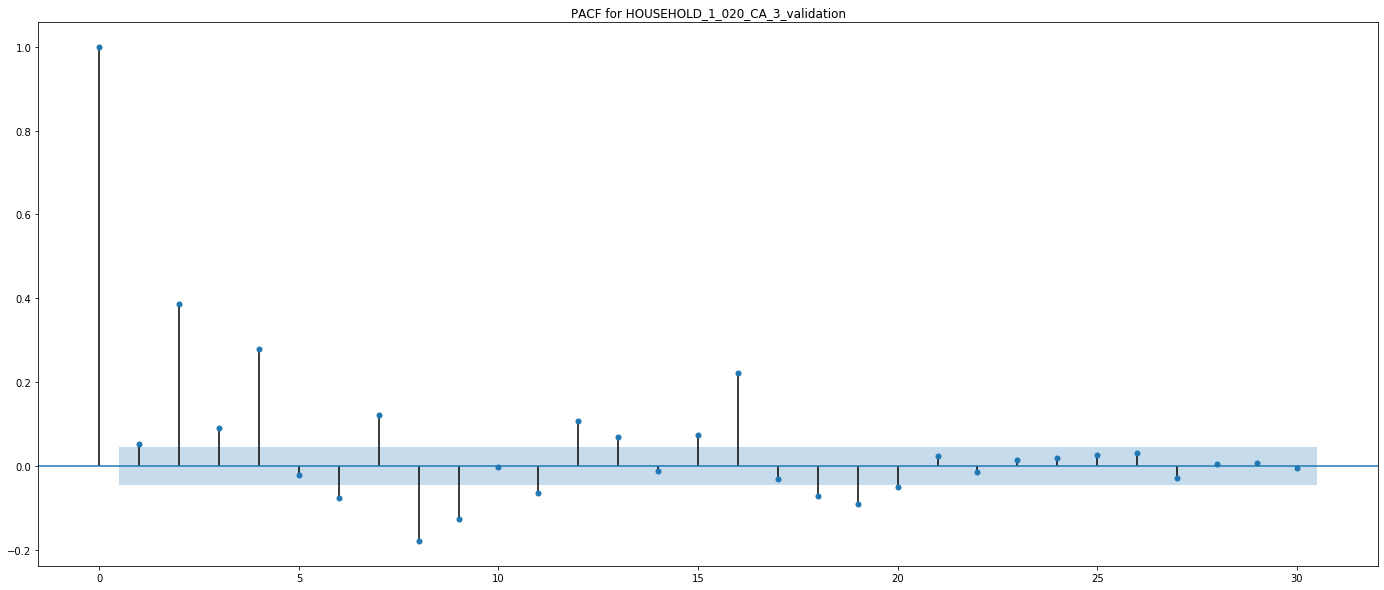

In [13]:
for product in top_10_products:
    make_pacf(product)
for product in bottom_10_products:
    make_pacf(product)

# ARIMA Model

In [14]:
df_just_1 = df.loc[df['id'] == 'FOODS_3_090_CA_3_validation']
df_just_1.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace = True, axis = 1)
    
melted_df = pd.melt(df_just_1, id_vars = 'id', var_name = 'date', value_name = 'quantity_purchased')
melted_df.drop(['id'], axis = 1, inplace = True)
    
together_now = pd.merge(melted_df, df_cal, left_on = 'date', right_on = 'd', how = 'inner')
together_now.drop(['date_x', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 1, inplace = True)
together_now.set_index('date_y', inplace = True)

In [15]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(together_now,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 25070.391029301358
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 23935.46646919792
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 23153.920996179222
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 22447.125369058536
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 22969.410894369437
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 22585.552292355358
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 22720.56833672687
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 22414.15634327905
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 23465.575530974136
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 22811.917311735597
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 22584.1919260812
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 21684.736316002418
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 22302.28539267336
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 21816.47393797018

In [17]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic             21066
Name: 63, dtype: object

In [53]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(together_now, 
                                        order=(0, 1, 2), 
                                        seasonal_order=(2, 0, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4633      0.014    -32.938      0.000      -0.491      -0.436
ma.L2         -0.2500      0.017    -14.990      0.000      -0.283      -0.217
ar.S.L12      -0.4393      0.005    -94.481      0.000      -0.448      -0.430
ar.S.L24      -0.9911      0.003   -290.780      0.000      -0.998      -0.984
ma.S.L12       0.4421      0.012     37.808      0.000       0.419       0.465
ma.S.L24       0.9908      0.033     30.095      0.000       0.926       1.055
sigma2      3670.0113    105.117     34.913      0.000    3463.985    3876.038


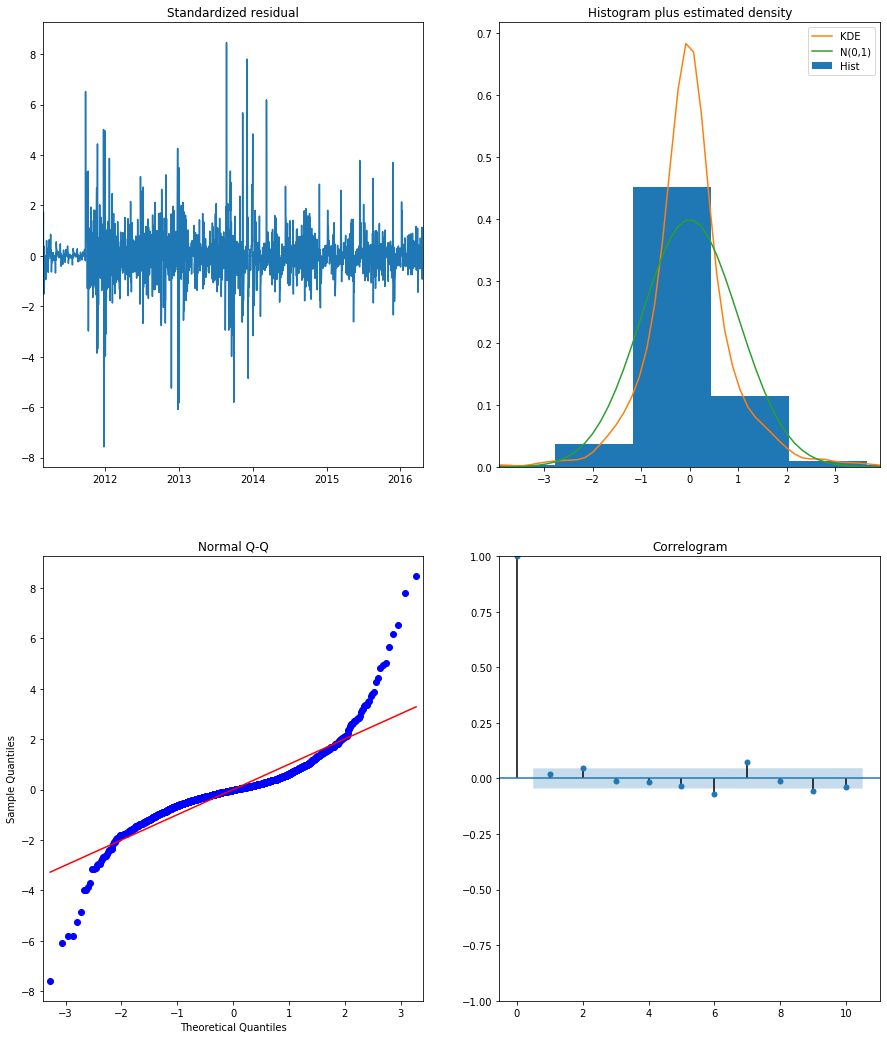

In [20]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [21]:
prediction = output.get_forecast(steps=28)
pred_conf = prediction.conf_int()

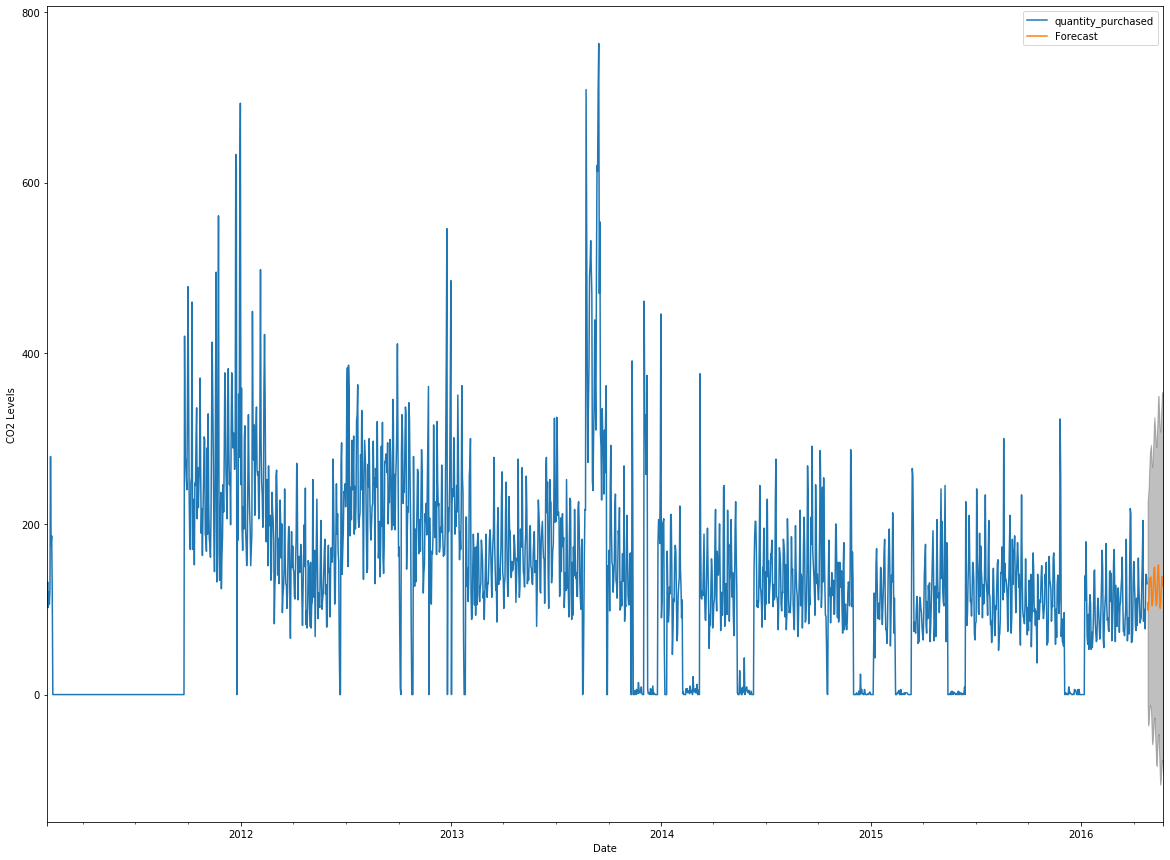

In [22]:
ax = together_now.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [23]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

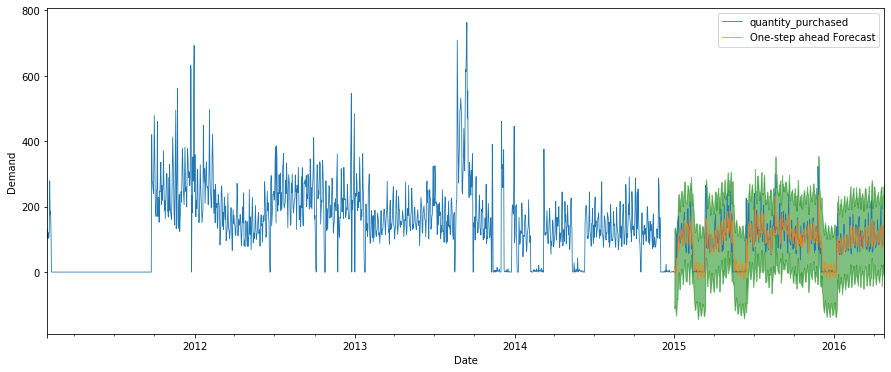

In [24]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = together_now['2011':].plot(label='observed', linewidth = .8)

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9, linewidth = .8)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [25]:
demand_forecasted = pred.predicted_mean
demand_truth = together_now['2015-01-01':]
demand_truth = pd.Series(demand_truth['quantity_purchased'])

# Compute the mean square error
rmse = np.sqrt(((demand_forecasted - demand_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 39.68


In [26]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

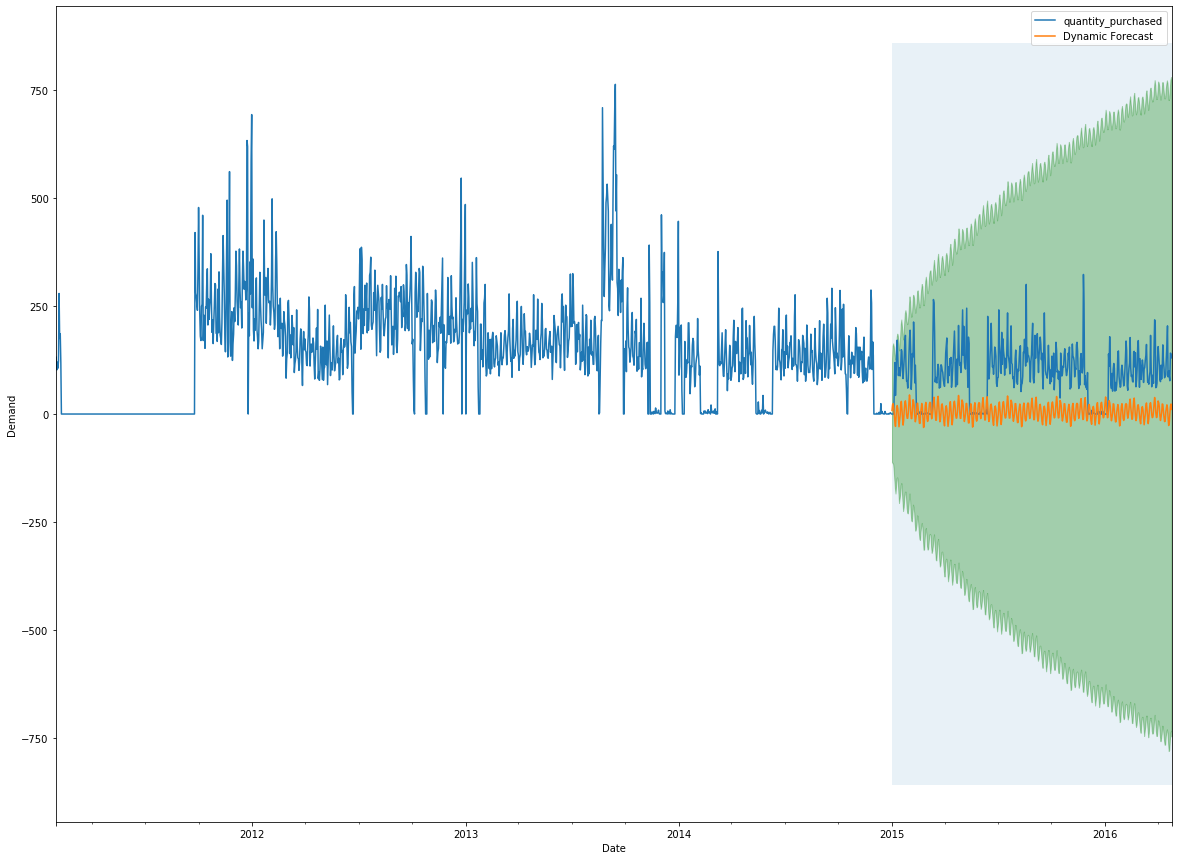

In [27]:
ax = together_now['2011':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), together_now.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

In [28]:
demand_forecasted = pred_dynamic.predicted_mean
demand_truth = together_now['2015-01-01':]
demand_truth = pd.Series(demand_truth['quantity_purchased'])

# Compute the mean square error
rmse = np.sqrt(((demand_forecasted - demand_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 105.77


In [29]:
prediction = output.get_forecast(steps=28)
pred_conf = prediction.conf_int()

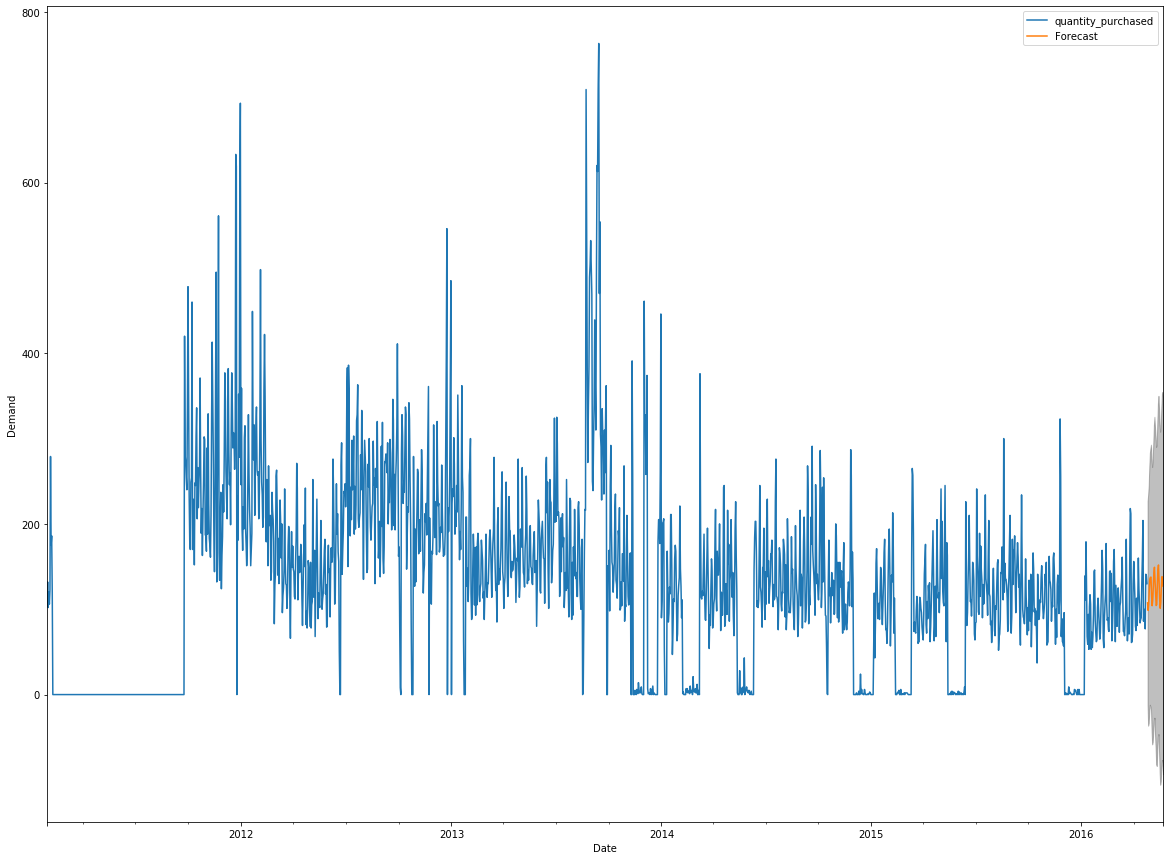

In [30]:
ax = together_now.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

In [62]:
list_of_errors = []

def model_and_rmse(item):
    # Format data frame
    df_just_1 = df.loc[df['id'] == item]
    df_just_1.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace = True, axis = 1)
    
    melted_df = pd.melt(df_just_1, id_vars = 'id', var_name = 'date', value_name = 'quantity_purchased')
    melted_df.drop(['id'], axis = 1, inplace = True)
    
    together_now = pd.merge(melted_df, df_cal, left_on = 'date', right_on = 'd', how = 'inner')
    together_now.drop(['date_x', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 1, inplace = True)
    together_now.set_index('date_y', inplace = True)
    
    # Istantiate an ARIMA model
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(together_now, 
                                        order=(0, 1, 2), 
                                        seasonal_order=(2, 0, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    # Determine RMSE
    pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
    pred_conf = pred.conf_int()
    
    demand_forecasted = pred.predicted_mean
    demand_truth = together_now['2015-01-01':]
    demand_truth = pd.Series(demand_truth['quantity_purchased'])

    # Compute the mean square error
    rmse = np.sqrt(((demand_forecasted - demand_truth) ** 2).mean())
    
    list_of_errors.append(rmse)

In [32]:
for prod in top_10_products:
    model_and_rmse(prod)

In [54]:
sum(list_of_errors)/10

22.250065079069174